# 14. Utility-Scale Experiment III

Toshinari Itoko, Tamiya Onodera, Kifumi Numata (July 19, 2024)<br>
© IBM Corp. 2024

*Approximate QPU time to run this experiment is 12 m 30 s.*

In [1]:
import qiskit
qiskit.__version__

'1.3.0'

In [2]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.__version__

'0.34.0'

In [3]:
import numpy as np
import rustworkx as rx
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_gate_map
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers import BackendV2
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import TranspileLayout

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler, Estimator, Batch, SamplerOptions

Let us briefly review GHZ states, and what sort of distribution you might expect from ```Sampler``` applied to one. Then we will spell out the goal of this lesson explicitly.

###  GHZ state

The GHZ state (Greenberger-Horne-Zeilinger state) for $n$ qubits is defined as

$$\frac{1}{\sqrt 2}(|0\rangle ^ {\otimes n}+ |1\rangle^ {\otimes n})$$

Naturally, it can be created for 6 qubits with the following quantum circuit.

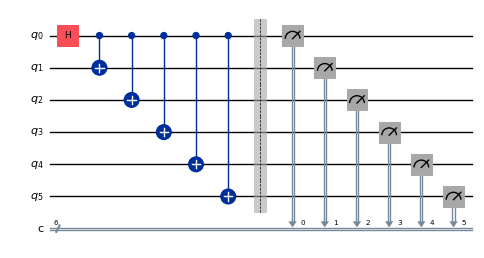

In [4]:
N = 6
qc = QuantumCircuit(N, N)

qc.h(0)
for i in range(N-1):
    qc.cx(0,i+1)

#qc.measure_all()
qc.barrier()
qc.measure(list(range(N)), list(range(N)))

qc.draw(output="mpl", idle_wires=False, scale=0.5)

In [5]:
print('Depth:', qc.depth())

Depth: 7


The depth is not too large, though you know from previous lessons that you can do better. Let's pick a backend and transpile this circuit.

In [ ]:
service = QiskitRuntimeService()
backend = service.backend("ibm_kyiv")
# or 
#backend = service.least_busy(operational=True)
#backend.name

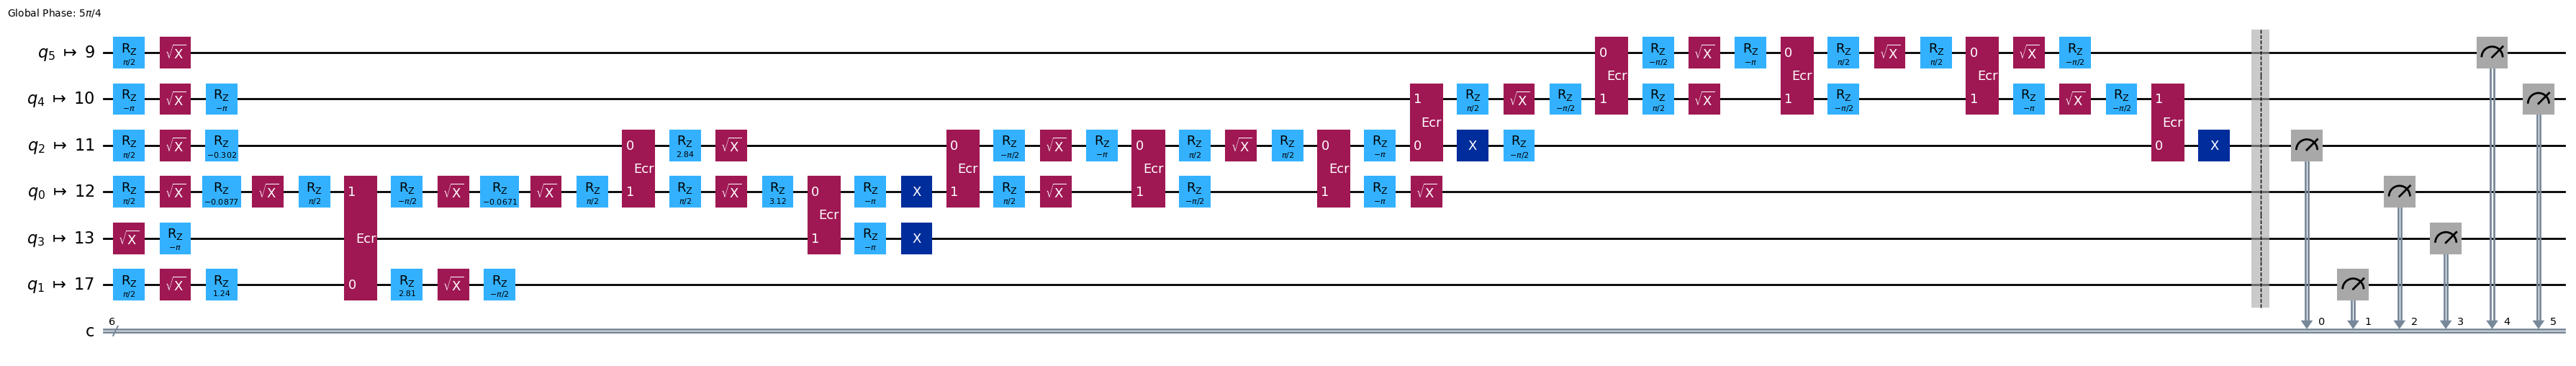

In [6]:
pm = generate_preset_pass_manager(3, backend=backend)
qc_transpiled = pm.run(qc)
qc_transpiled.draw(output="mpl", idle_wires=False, fold=-1)

In [7]:
print('Depth:', qc_transpiled.depth())
print('Two-qubit Depth:', qc_transpiled.depth(filter_function=lambda x: x.operation.num_qubits==2))

Depth: 47
Two-qubit Depth: 11


Again the transpiled two-qubit depth is not too large. But to work with a GHZ state on more qubits, you will clearly need to think about optimizing the circuit. Let's run this using ```Sampler``` and see what a real quantum computer returns.

In [8]:
sampler = Sampler(mode=backend)
shots = 40000
job = sampler.run([qc_transpiled], shots = shots)
print("job id:", job.job_id())

job id: cv3adfdhdzz0008mf3dg


In [8]:
job = service.job('cv3adfdhdzz0008mf3dg') # Use your job id shown above.
job.status()

'DONE'

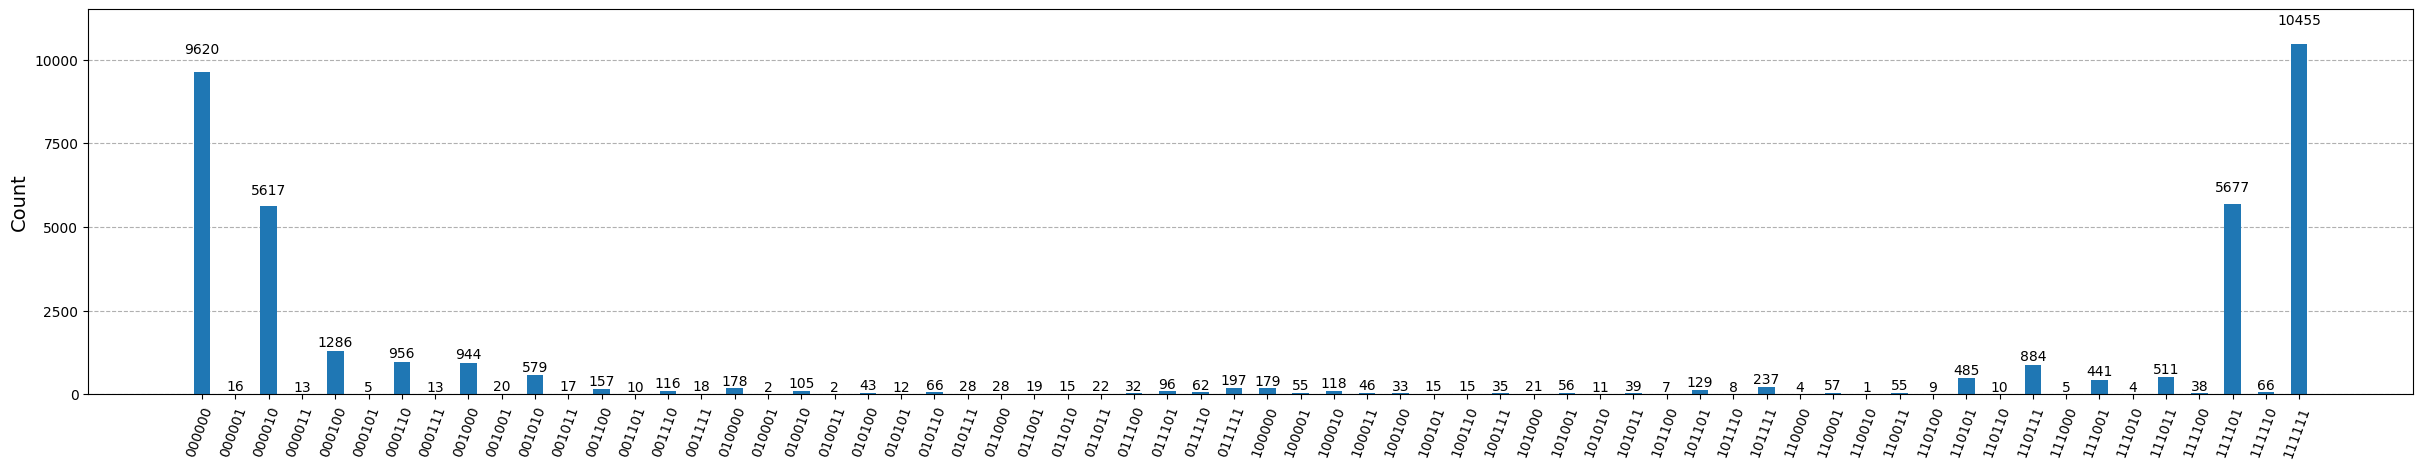

In [9]:
result = job.result()
plot_histogram(result[0].data.c.get_counts(), figsize=(30, 5))

This is the result of the 6-qubit GHZ circuit. As you can see, the states of all $|0\rangle$'s and all $|1\rangle$'s do dominate, but the errors are substantial. Let's try to see how large a GHZ circuit you can make with an Eagle device, while still getting results where the correct states are at least more than 50% likely.

## Your goal
    
Build a GHZ circuit for 20 qubits or more so that, upon measurement, **the fidelity of your GHZ state > 0.5.**
Note:
- You need to use an Eagle device (`ibm_kyiv`, etc.) and set the shots number as 40,000.
- You should execute the GHZ circuit using the `execute_ghz_fidelity` function, and calculate the fidelity using the `check_ghz_fidelity_from_jobs` function.

This is intended as an independent exercise, in which you leverage what you have learned so far in this course.

In [6]:
def execute_ghz_fidelity(
    ghz_circuit: QuantumCircuit,  # Quantum circuit to create GHZ state (Circuit after Routing or without Routing), Classical register name is "c"
    physical_qubits: list[int],  # Physical qubits to represent GHZ state
    backend: BackendV2,
    sampler_options: dict | SamplerOptions | None = None,
):
    N_SHOTS = 40_000
    N = len(physical_qubits)
    base_circuit = ghz_circuit.remove_final_measurements(inplace=False)
    # M_k measurement circuits
    mk_circuits = []
    for k in range(1, N + 1):
        circuit = base_circuit.copy()
        # change mesurement basis
        for q in physical_qubits:
            circuit.rz(-k * np.pi / N, q)
            circuit.h(q)
        mk_circuits.append(circuit)

    obs = SparsePauliOp.from_sparse_list(
        [("Z" * N, physical_qubits, 1)], num_qubits=backend.num_qubits
    )
    job_ids = []
    pm1 = generate_preset_pass_manager(1, backend=backend)
    org_transpiled = pm1.run(ghz_circuit)
    mk_transpiled = pm1.run(mk_circuits)
    with Batch(backend=backend):
        sampler = Sampler(options=sampler_options)
        sampler.options.twirling.enable_measure = True
        job = sampler.run([org_transpiled], shots=N_SHOTS)
        job_ids.append(job.job_id())
        print(f"Sampler job id: {job.job_id()}, shots={N_SHOTS}")
        estimator = Estimator()  # TREX is applied as default
        estimator.options.dynamical_decoupling.enable = True
        estimator.options.execution.rep_delay = 0.0005
        estimator.options.twirling.enable_measure = True
        job2 = estimator.run([(circ, obs) for circ in mk_transpiled], precision=1 / 100)
        job_ids.append(job2.job_id())
        print("Estimator job id:", job2.job_id())

In [7]:
def check_ghz_fidelity_from_jobs(
    sampler_job,
    estimator_job,
    num_qubits,
    shots = 40_000,
):
    N = num_qubits
    sampler_result = sampler_job.result()
    counts = sampler_result[0].data.c.get_counts()
    all_zero = counts.get("0" * N, 0) / shots
    all_one = counts.get("1" * N, 0) / shots
    top3 = sorted(counts, key=counts.get, reverse=True)[:3]
    print(f"N={N}: |00..0>: {counts.get('0'*N, 0)}, |11..1>: {counts.get('1'*N, 0)}, |3rd>: {counts.get(top3[2], 0)} ({top3[2]})")
    print(f"P(|00..0>)={all_zero}, P(|11..1>)={all_one}")

    estimator_result = estimator_job.result()
    non_diagonal = (1 / N) * sum(
        (-1) ** k * estimator_result[k - 1].data.evs for k in range(1, N + 1)
    )
    print(f"REM: Coherence (non-diagonal): {non_diagonal:.6f}")
    fidelity = 0.5 * (all_zero + all_one + non_diagonal)
    sigma = 0.5 * np.sqrt(
        (1 - all_zero - all_one) * (all_zero + all_one) / shots
        + sum(estimator_result[k].data.stds ** 2 for k in range(N)) / (N * N)
    )
    print(f"GHZ fidelity = {fidelity:.6f} ± {sigma:.6f}")
    if fidelity - 2 * sigma > 0.5:
        print("GME (genuinely multipartite entangled) test: Passed")
    else:
        print("GME (genuinely multipartite entangled) test: Failed")
    return {
        "fidelity": fidelity,
        "sigma": sigma,
        "shots": shots,
        "job_ids": [sampler_job.job_id(), estimator_job.job_id()],
    }

In this notebook, we will apply three strategies to creating good GHZ states using 16 qubits and 30 qubits. These approaches build on strategies you already know from previous lessons.

## Strategy 1. Noise-aware qubit selection

We first specify a backend. Because we will be working extensively with the properties of a specific backend, it is a good idea to specify one backend, as opposed to using the ```least_busy``` option.

In [ ]:
backend = service.backend("ibm_kyiv")
twoq_gate = "ecr"
print(f"Device {backend.name} Loaded with {backend.num_qubits} qubits")
print(f"Two Qubit Gate: {twoq_gate}")

We are going to build a circuit involving many two-qubit gates. It makes sense for us to use the qubits that have the lowest errors when implementing those two-qubit gates. Finding the best "qubit chain" based on the reported 2q-gate errors is a not-trivial problem. But we can define a few functions to help us determine the best qubits to use.

In [9]:
coupling_map = backend.target.build_coupling_map(twoq_gate)
G = coupling_map.graph

In [10]:
def to_edges(path): #create edges list from node paths
    edges = []
    prev_node = None
    for node in path:
        if prev_node is not None:
            if G.has_edge(prev_node, node):
                edges.append((prev_node, node))
            else:
                edges.append((node, prev_node))
        prev_node = node
    return edges


def path_fidelity(path, correct_by_duration: bool = True, readout_scale: float = None):
    """Compute an estimate of the total fidelity of 2-qubit gates on a path.
    If `correct_by_duration` is true, each gate fidelity is worsen by
    scale = max_duration / duration, i.e. gate_fidelity^scale.
    If `readout_scale` > 0 is supplied, readout_fidelity^readout_scale
    for each qubit on the path is multiplied to the total fielity.
    The path is given in node indices form, e.g. [0, 1, 2].
    An external function `to_edges` is used to obtain edge list, e.g. [(0, 1), (1, 2)]."""
    path_edges = to_edges(path)
    max_duration = max(backend.target[twoq_gate][qs].duration for qs in path_edges)

    def gate_fidelity(qpair):
        duration = backend.target[twoq_gate][qpair].duration
        scale = max_duration / duration if correct_by_duration else 1.0
        # 1.25 = (d+1)/d with d = 4
        return max(0.25, 1 - (1.25 * backend.target[twoq_gate][qpair].error)) ** scale

    def readout_fidelity(qubit):
        return max(0.25, 1 - backend.target["measure"][(qubit,)].error)

    total_fidelity = np.prod([gate_fidelity(qs) for qs in path_edges]) #two qubits gate fidelity for each path
    if readout_scale:
        total_fidelity *= np.prod([readout_fidelity(q) for q in path]) ** readout_scale # multipy readout fidelity
    return total_fidelity


def flatten(paths, cutoff=None):  # cutoff is for not making run time too large
    return [
        path
        for s, s_paths in paths.items()
        for t, st_paths in s_paths.items()
        for path in st_paths[:cutoff]
        if s < t
    ]

In [11]:
N = 16 # Number of qubits to use in the GHZ circuit
num_qubits_in_chain = N

We will use the functions above to find all the simple paths of N qubits between all pairs of nodes in the graph (Reference: [all_pairs_all_simple_paths](https://www.rustworkx.org/apiref/rustworkx.all_pairs_all_simple_paths.html#rustworkx-all-pairs-all-simple-paths)).

Then, using the `path_fidelity` function created above, we will find the best qubit chain which has the largest path fidelity.

In [12]:
%%time
paths = rx.all_pairs_all_simple_paths(
    G.to_undirected(multigraph=False),
    min_depth=num_qubits_in_chain,
    cutoff=num_qubits_in_chain,
)
paths = flatten(paths, cutoff=25)  # If you have time, you could set a larger cutoff.
if not paths:
    raise Exception(
        f"No qubit chain with length={num_qubits_in_chain} exists in {backend.name}. Try smaller num_qubits_in_chain."
    )

print(f"Selecting the best from {len(paths)} candidate paths")
from functools import partial
best_qubit_chain = max(paths, key=partial(path_fidelity, correct_by_duration=True, readout_scale=1.0))
assert len(best_qubit_chain) == num_qubits_in_chain
print(f"Predicted (best possible) process fidelity: {path_fidelity(best_qubit_chain)}")

Selecting the best from 6046 candidate paths
Predicted (best possible) process fidelity: 0.8916365774711382
CPU times: user 345 ms, sys: 5.59 ms, total: 351 ms
Wall time: 355 ms


In [13]:
np.array(best_qubit_chain)

array([59, 60, 53, 41, 42, 43, 44, 45, 54, 64, 65, 66, 73, 85, 84, 83],
      dtype=uint64)

Let's plot the best qubit chain, shown in pink, in the coupling map diagram.

In [ ]:
qubit_color = []
for i in range(133):
    if i in best_qubit_chain:
        qubit_color.append("#ff00dd") #pink
    else:
        qubit_color.append("#8c00ff") #purple
plot_gate_map(backend, qubit_color=qubit_color, qubit_size=50, font_size=25, figsize=(6, 6))

### Build a GHZ circuit on the best qubit chain

We choose a qubit in the middle of the chain to first apply the H gate to. This should reduce the depth of the circuit by about half.

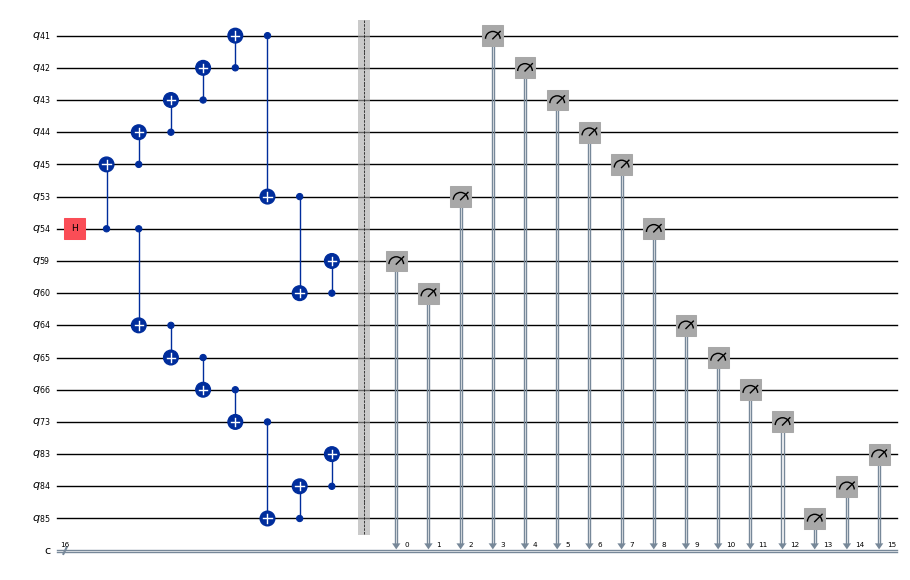

In [15]:
ghz1 = QuantumCircuit(max(best_qubit_chain)+1, N)
ghz1.h(best_qubit_chain[N//2])
for i in range(N//2, 0, -1):
    ghz1.cx(best_qubit_chain[i], best_qubit_chain[i-1])
for i in range(N//2, N-1, +1):
    ghz1.cx(best_qubit_chain[i], best_qubit_chain[i+1])
ghz1.barrier()  # for visualization
ghz1.measure(best_qubit_chain, list(range(N)))
ghz1.draw(output="mpl", idle_wires=False, scale=0.5, fold=-1)

In [16]:
ghz1.depth()

10

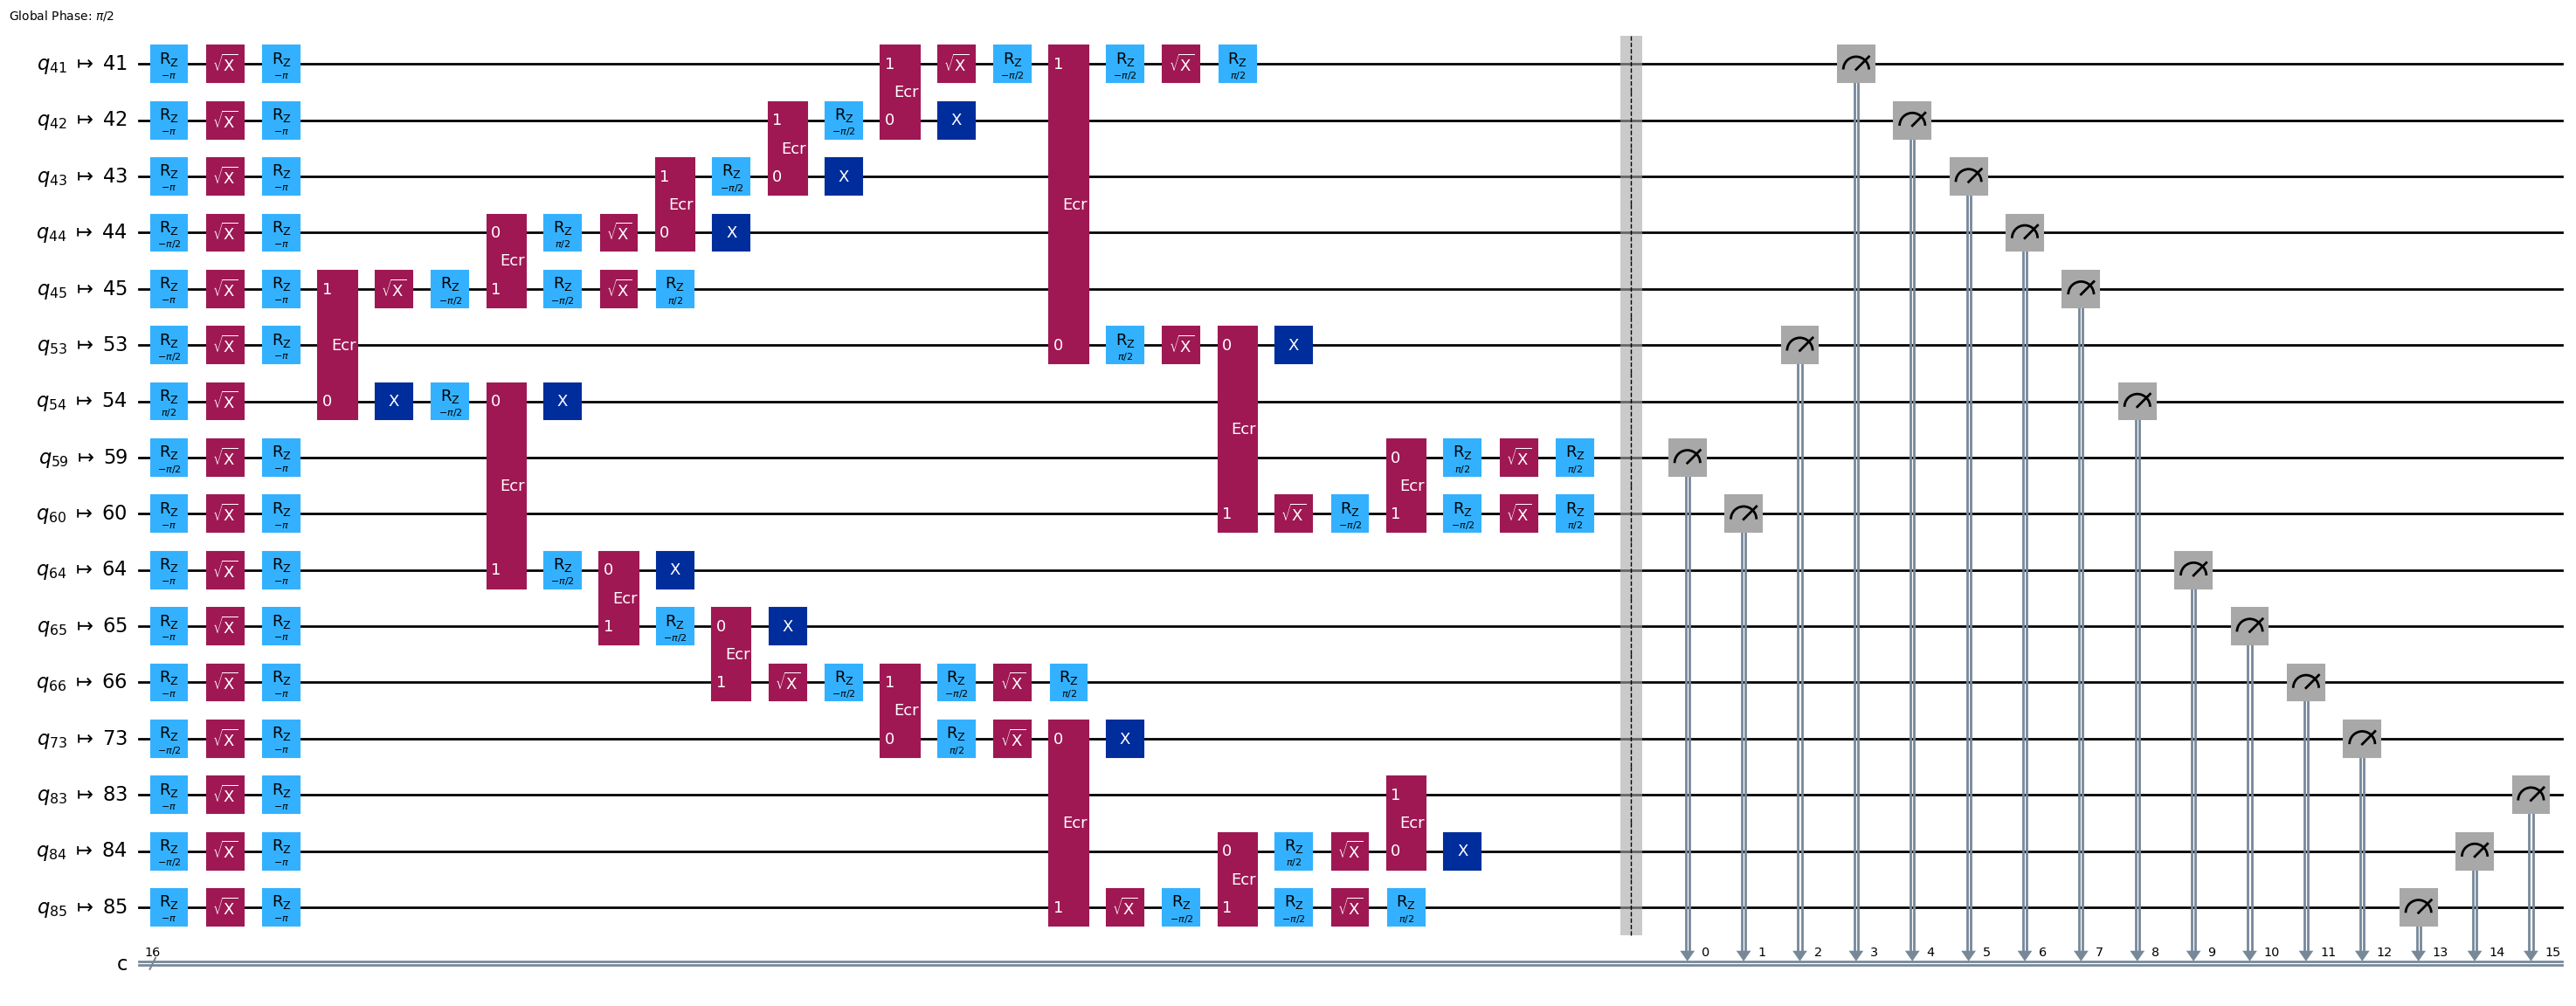

In [17]:
pm = generate_preset_pass_manager(1, backend=backend)
ghz1_transpiled = pm.run(ghz1)
ghz1_transpiled.draw(output="mpl", idle_wires=False, fold=-1)

In [18]:
print('Depth:', ghz1_transpiled.depth())
print('Two-qubit Depth:', ghz1_transpiled.depth(filter_function=lambda x: x.operation.num_qubits==2))

Depth: 27
Two-qubit Depth: 8


In [37]:
opts = SamplerOptions()

In [20]:
res = execute_ghz_fidelity(
    ghz_circuit=ghz1,
    physical_qubits=best_qubit_chain,
    backend=backend,
    sampler_options=opts,
)

Sampler job id: cv3dgs3qxmm00089yca0, shots=40000
Estimator job id: cv3dgwk12hg0008f2af0


In [40]:
job_s = service.job('cv3dgs3qxmm00089yca0') # Use your job id showed above. 
job_e = service.job('cv3dgwk12hg0008f2af0')
print(job_s.status(), job_e.status())

DONE DONE


Be careful to execute the next cell after the above jobs statuses have become 'DONE', to show the result using the `check_ghz_fidelity_from_jobs` function.

In [41]:
N = 16
# Check fidelity from job IDs
res = check_ghz_fidelity_from_jobs(
    sampler_job=job_s,
    estimator_job=job_e,
    num_qubits=N,
)

N=16: |00..0>: 1163, |11..1>: 12918, |3rd>: 3835 (0000000010000000)
P(|00..0>)=0.029075, P(|11..1>)=0.32295
REM: Coherence (non-diagonal): 0.330655
GHZ fidelity = 0.341340 ± 0.003363
GME (genuinely multipartite entangled) test: Failed


In [ ]:
result = job_s.result()
plot_histogram(result[0].data.c.get_counts(), figsize=(30, 5))

This result does not meet the criteria. Let's move to the next idea.

## Strategy 2. Balanced tree of qubits

The next idea is to find a balanced tree of qubits. Using the tree rather than the chain, the circuit depth should become lower. Before that, we remove nodes with "bad" readout errors and edges with "bad" gate errors from the coupling graph.

In [16]:
BAD_READOUT_ERROR_THRESHOLD = 0.1
BAD_ECRGATE_ERROR_THRESHOLD = 0.1
bad_readout_qubits = [q for q in range(backend.num_qubits) if backend.target["measure"][(q, )].error > BAD_READOUT_ERROR_THRESHOLD]
bad_ecrgate_edges = [qpair for qpair in backend.target["ecr"] if backend.target["ecr"][qpair].error > BAD_ECRGATE_ERROR_THRESHOLD]
print("Bad readout qubits:", bad_readout_qubits)
print("Bad ECR gates:", bad_ecrgate_edges)

Bad readout qubits: [0, 1, 3, 14, 18, 28, 37, 57, 76, 90, 108, 117]
Bad ECR gates: [(76, 77), (94, 90), (106, 107), (107, 108), (112, 108), (117, 116), (118, 117)]


In [17]:
g = backend.coupling_map.graph.copy().to_undirected()
g.remove_edges_from(bad_ecrgate_edges)  # remove edge first (otherwise may fail with a NoEdgeBetweenNodes error)
g.remove_nodes_from(bad_readout_qubits)

Let's draw the coupling map graph without the bad edges and bad qubits.

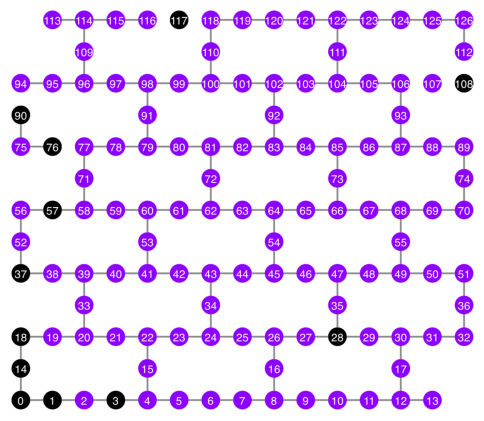

In [18]:
qubit_color = []
for i in range(133):
    if i in bad_readout_qubits:
        qubit_color.append("#000000") #black
    else:
        qubit_color.append("#8c00ff") #purple
line_color = []
for e in backend.target.build_coupling_map().get_edges():
    if e in bad_ecrgate_edges:
        line_color.append("#ffffff") #white
    else:
        line_color.append("#888888") #gray
plot_gate_map(backend, qubit_color=qubit_color, line_color=line_color, qubit_size=50, font_size=25, figsize=(6, 6))

We try to create a 16 qubit GHZ state as before.

In [19]:
N = 16

We call the `betweenness_centrality` function to find a qubit for the root node. The node with the highest value of betweenness centrality is at the center of the graph. Reference: https://www.rustworkx.org/tutorial/betweenness_centrality.html 

Or you can select it manually.

In [20]:
#central = 65 #Select the center node manually
c_degree = dict(rx.betweenness_centrality(g))
central = max(c_degree, key=c_degree.get)
central

43

Starting from the root node, generate a tree by breadth first search (BFS). Reference: https://qiskit.org/ecosystem/rustworkx/apiref/rustworkx.bfs_search.html#rustworkx-bfs-search

In [21]:
class TreeEdgesRecorder(rx.visit.BFSVisitor):
    def __init__(self, N):
        self.edges = []
        self.N = N

    def tree_edge(self, edge):
        self.edges.append(edge)
        if len(self.edges) >= self.N-1:
            raise rx.visit.StopSearch()

vis = TreeEdgesRecorder(N)
rx.bfs_search(g, [central], vis)
best_qubits = sorted(list(set(q for e in vis.edges for q in (e[0], e[1]))))
#print('Tree edges:', vis.edges)

In [27]:
print('Qubits selected:', best_qubits)

Qubits selected: [23, 24, 25, 34, 39, 40, 41, 42, 43, 44, 45, 46, 53, 54, 60, 64]


Let us plot the selected qubits, shown in pink, in the coupling map diagram.

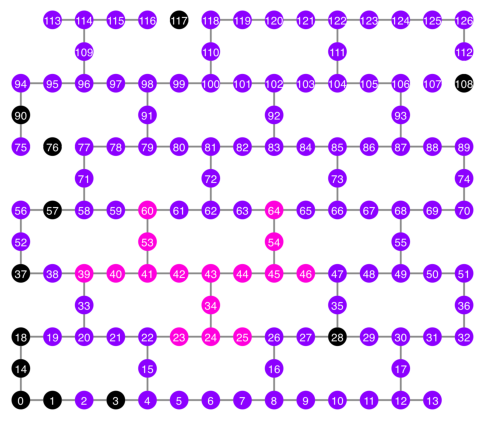

In [28]:
qubit_color = []
for i in range(133):
    if i in bad_readout_qubits:
        qubit_color.append("#000000") #black
    elif i in best_qubits:
        qubit_color.append("#ff00dd") #pink
    else:
        qubit_color.append("#8c00ff") #purple
plot_gate_map(backend, qubit_color=qubit_color, line_color=line_color, qubit_size=50, font_size=25, figsize=(6, 6))

Let us show the tree structure of qubits.

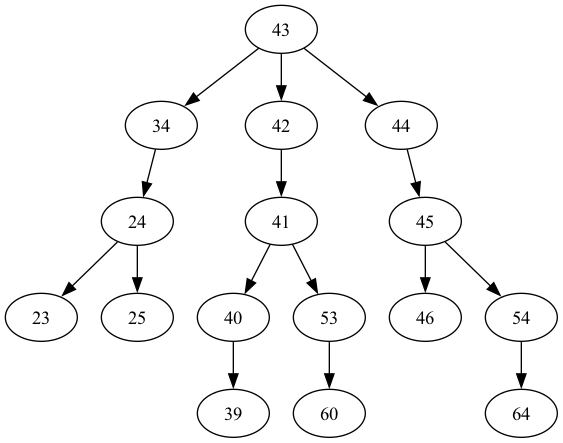

In [29]:
from rustworkx.visualization import graphviz_draw
tree = rx.PyDiGraph()
tree.extend_from_weighted_edge_list(vis.edges)
tree.remove_nodes_from([n for n in range(max(best_qubits)+1) if n not in best_qubits])

graphviz_draw(tree, method='dot')

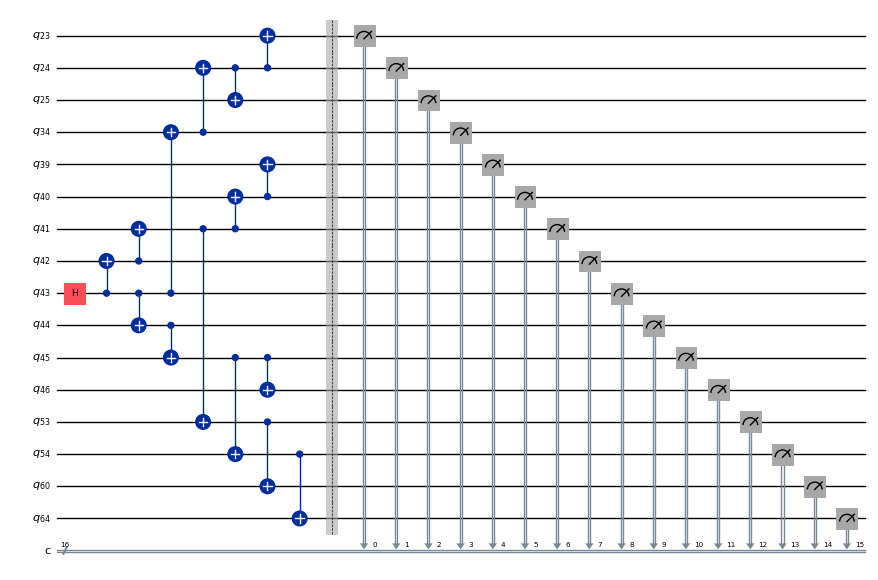

In [30]:
ghz2 = QuantumCircuit(max(best_qubits)+1, N)

ghz2.h(tree.edge_list()[0][0]) # apply H-gate to the root node
# Apply CNOT from the root node to the each edge.
for u, v in tree.edge_list():
    ghz2.cx(u, v)
ghz2.barrier()  # for visualization
ghz2.measure(best_qubits, list(range(N)))
ghz2.draw(output="mpl", idle_wires=False, scale=0.5)

In [31]:
ghz2.depth()

8

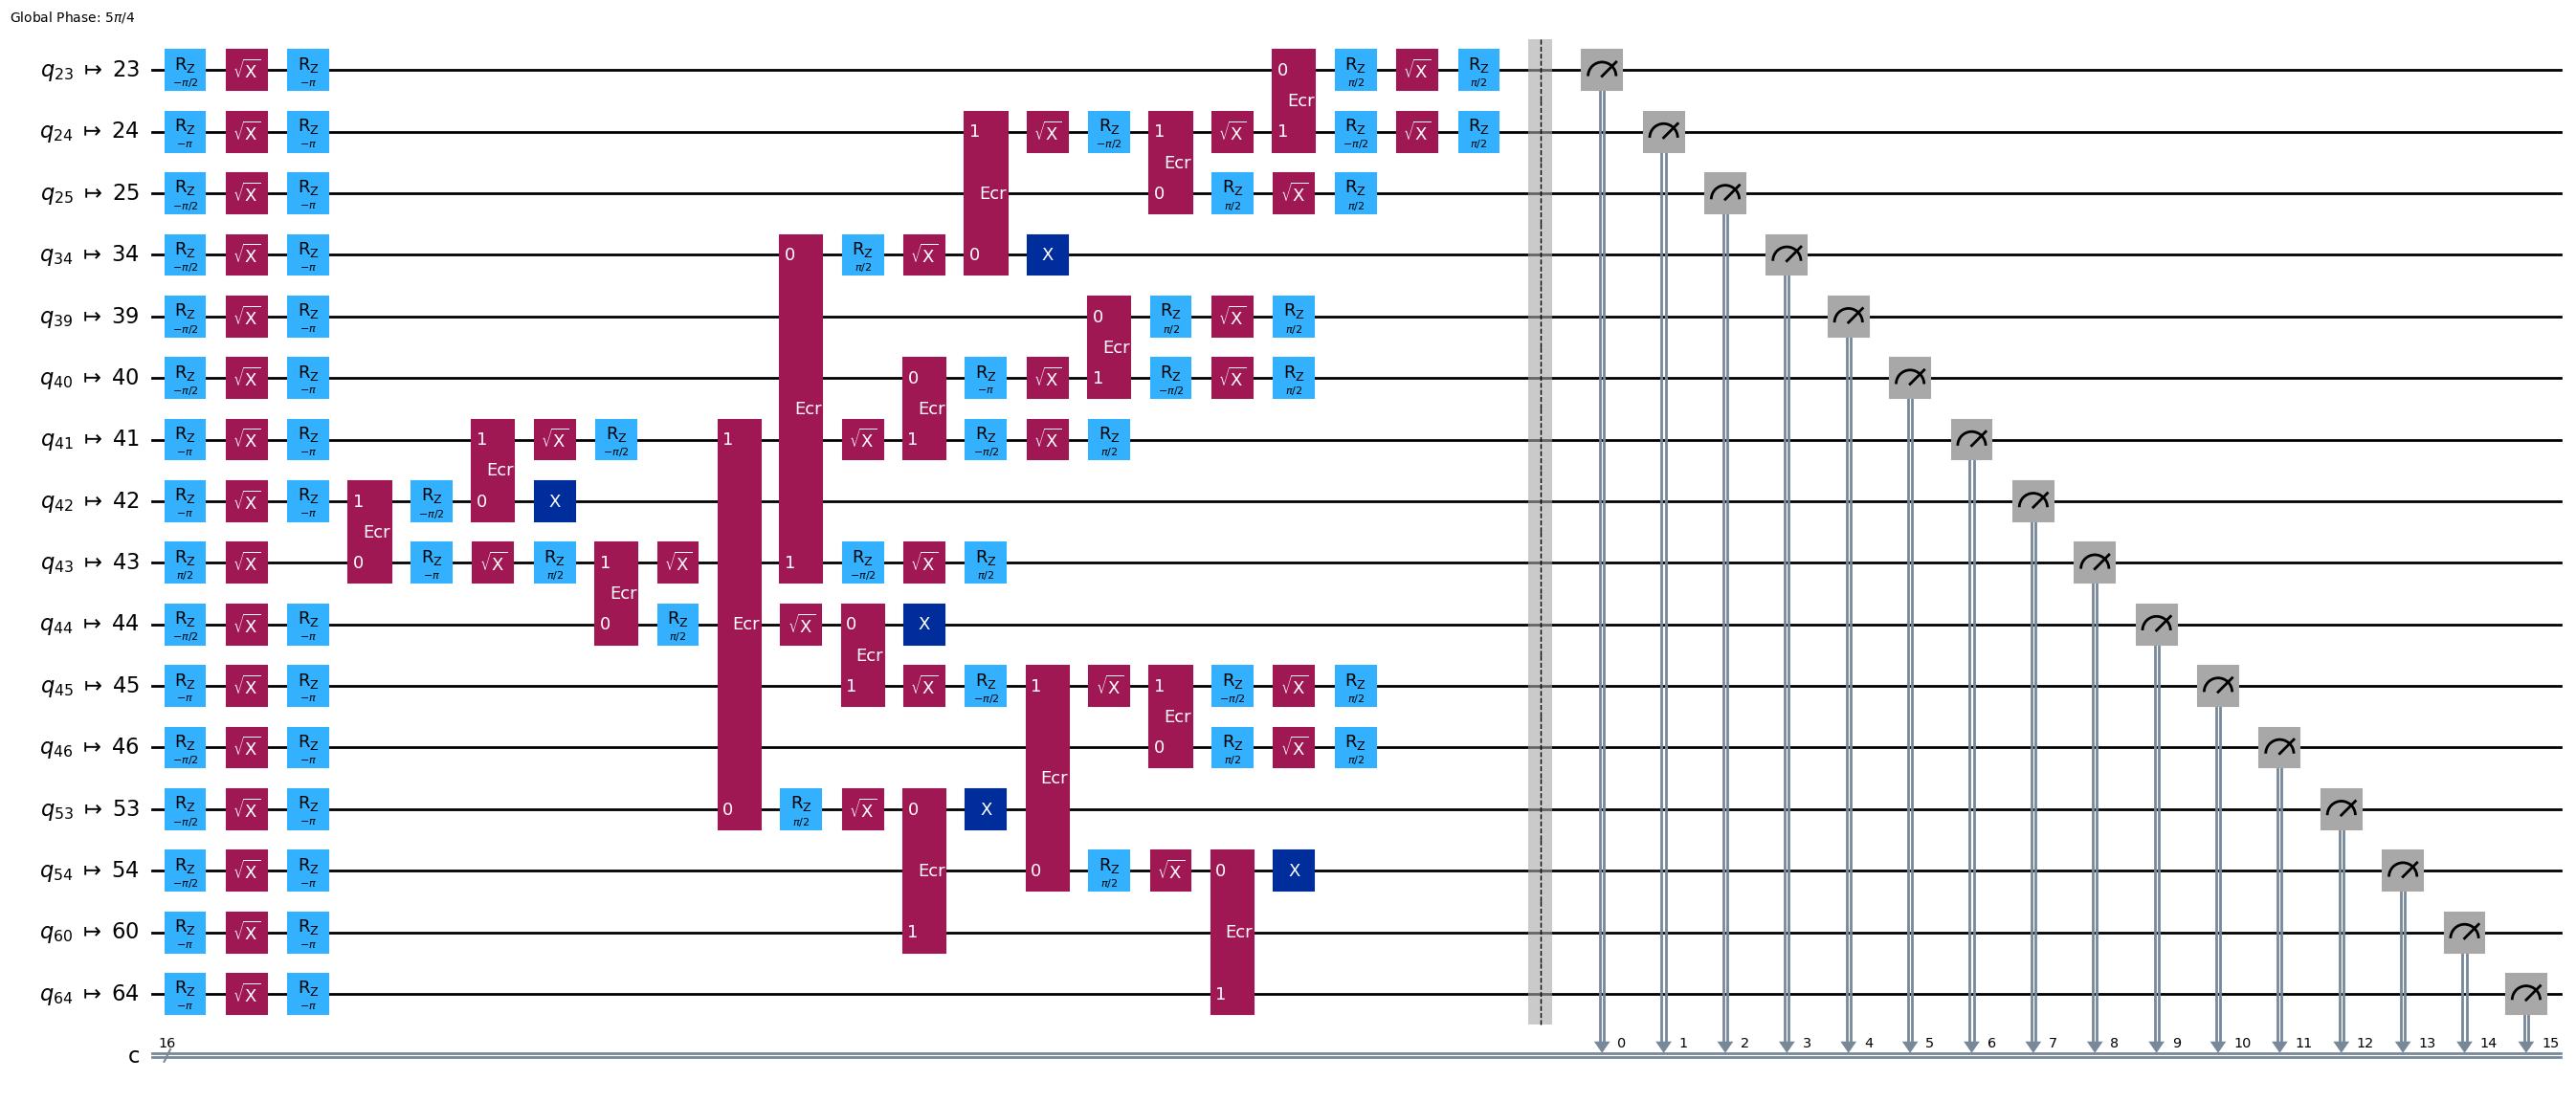

In [32]:
pm = generate_preset_pass_manager(1, backend=backend)
ghz2_transpiled = pm.run(ghz2)
ghz2_transpiled.draw(output="mpl", idle_wires=False, fold=-1)

In [33]:
print('Depth:', ghz2_transpiled.depth())
print('Two-qubit Depth:', ghz2_transpiled.depth(filter_function=lambda x: x.operation.num_qubits==2))

Depth: 22
Two-qubit Depth: 6


The depth of the circuit has now become much lower than that in the chain structure.

In [34]:
res = execute_ghz_fidelity(
    ghz_circuit=ghz2,
    physical_qubits=best_qubits,
    backend=backend,
    sampler_options=opts,
)

Sampler job id: cv3dh14fkm5g0085en3g, shots=40000
Estimator job id: cv3dh2cfkm5g0085en4g


In [37]:
job_s = service.job('cv3dh14fkm5g0085en3g') # Use your job id showed above. 
job_e = service.job('cv3dh2cfkm5g0085en4g')
print(job_s.status(), job_e.status())

DONE DONE


In [38]:
N=16
# Check fidelity from job IDs
res = check_ghz_fidelity_from_jobs(
    sampler_job=job_s,
    estimator_job=job_e,
    num_qubits=N,
)

N=16: |00..0>: 713, |11..1>: 11136, |3rd>: 1192 (1111111111111011)
P(|00..0>)=0.017825, P(|11..1>)=0.2784
REM: Coherence (non-diagonal): 1.104850
GHZ fidelity = 0.700538 ± 0.009835
GME (genuinely multipartite entangled) test: Passed


We have successfully passed the criteria with the balanced tree structure!

In [ ]:
result = job_s.result()
plot_histogram(result[0].data.c.get_counts(), figsize=(30, 5))

Now, let us try to create a larger GHZ state, that is a 30-qubit GHZ state.

### N = 30

We will follow the [Qiskit Patterns](https://docs.quantum.ibm.com/guides/intro-to-patterns).

- Step 1: Map problem to quantum circuits and operators
- Step 2: Optimize for target hardware
- Step 3: Execute on target hardware
- Step 4: Post-process results



**Step 1: Map problem to quantum circuits and operators** and **Step 2: Optimize for target hardware**

Here we select the root node manually.

In [22]:
central = 62 #Select the center node manually
#c_degree = dict(rx.betweenness_centrality(g))
#central = max(c_degree, key=c_degree.get)
#central

In [23]:
N = 30

vis = TreeEdgesRecorder(N)
rx.bfs_search(g, [central], vis)
best_qubits = sorted(list(set(q for e in vis.edges for q in (e[0], e[1]))))
print('Qubits selected:', best_qubits)

Qubits selected: [40, 41, 42, 44, 45, 46, 53, 54, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 71, 72, 73, 78, 79, 80, 81, 82, 83, 84, 91, 92]


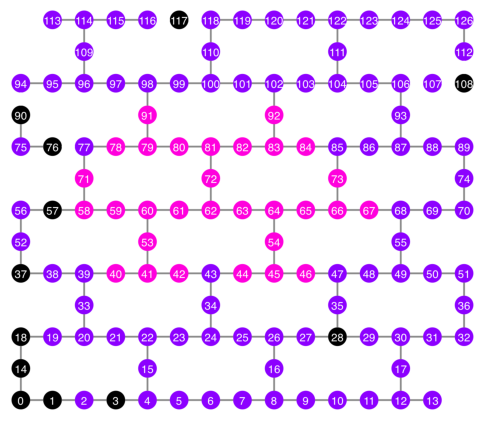

In [24]:
qubit_color = []
for i in range(133):
    if i in bad_readout_qubits:
        qubit_color.append("#000000")
    elif i in best_qubits:
        qubit_color.append("#ff00dd")
    else:
        qubit_color.append("#8c00ff")
line_color = []
for e in backend.target.build_coupling_map().get_edges():
    if e in bad_ecrgate_edges:
        line_color.append("#ffffff")
    else:
        line_color.append("#888888")
plot_gate_map(backend, qubit_color=qubit_color, line_color=line_color, qubit_size=50, font_size=25, figsize=(6, 6))

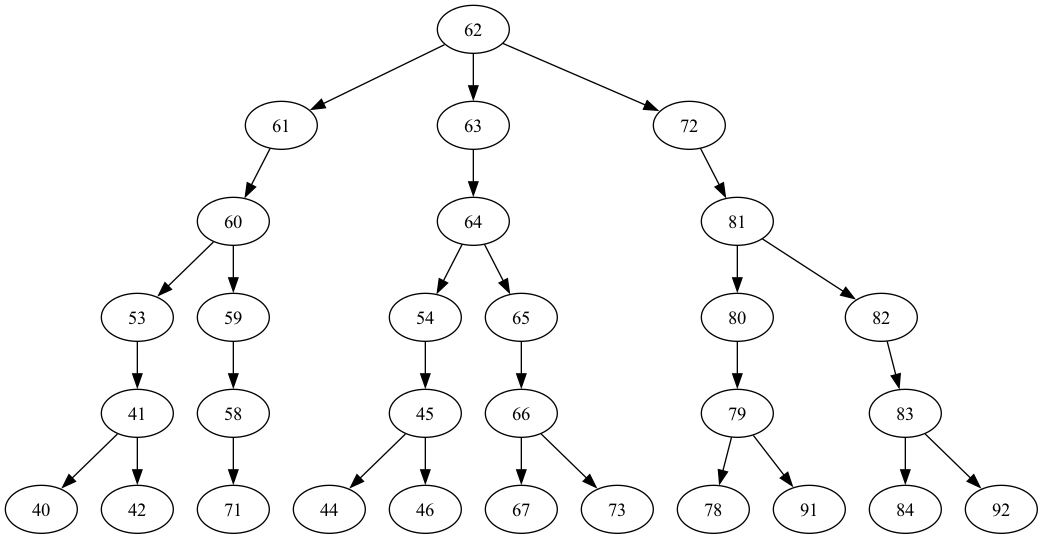

In [25]:
from rustworkx.visualization import graphviz_draw
tree = rx.PyDiGraph()
tree.extend_from_weighted_edge_list(vis.edges)
tree.remove_nodes_from([n for n in range(max(best_qubits)+1) if n not in best_qubits])

graphviz_draw(tree, method='dot')

The depth of this tree is 5.

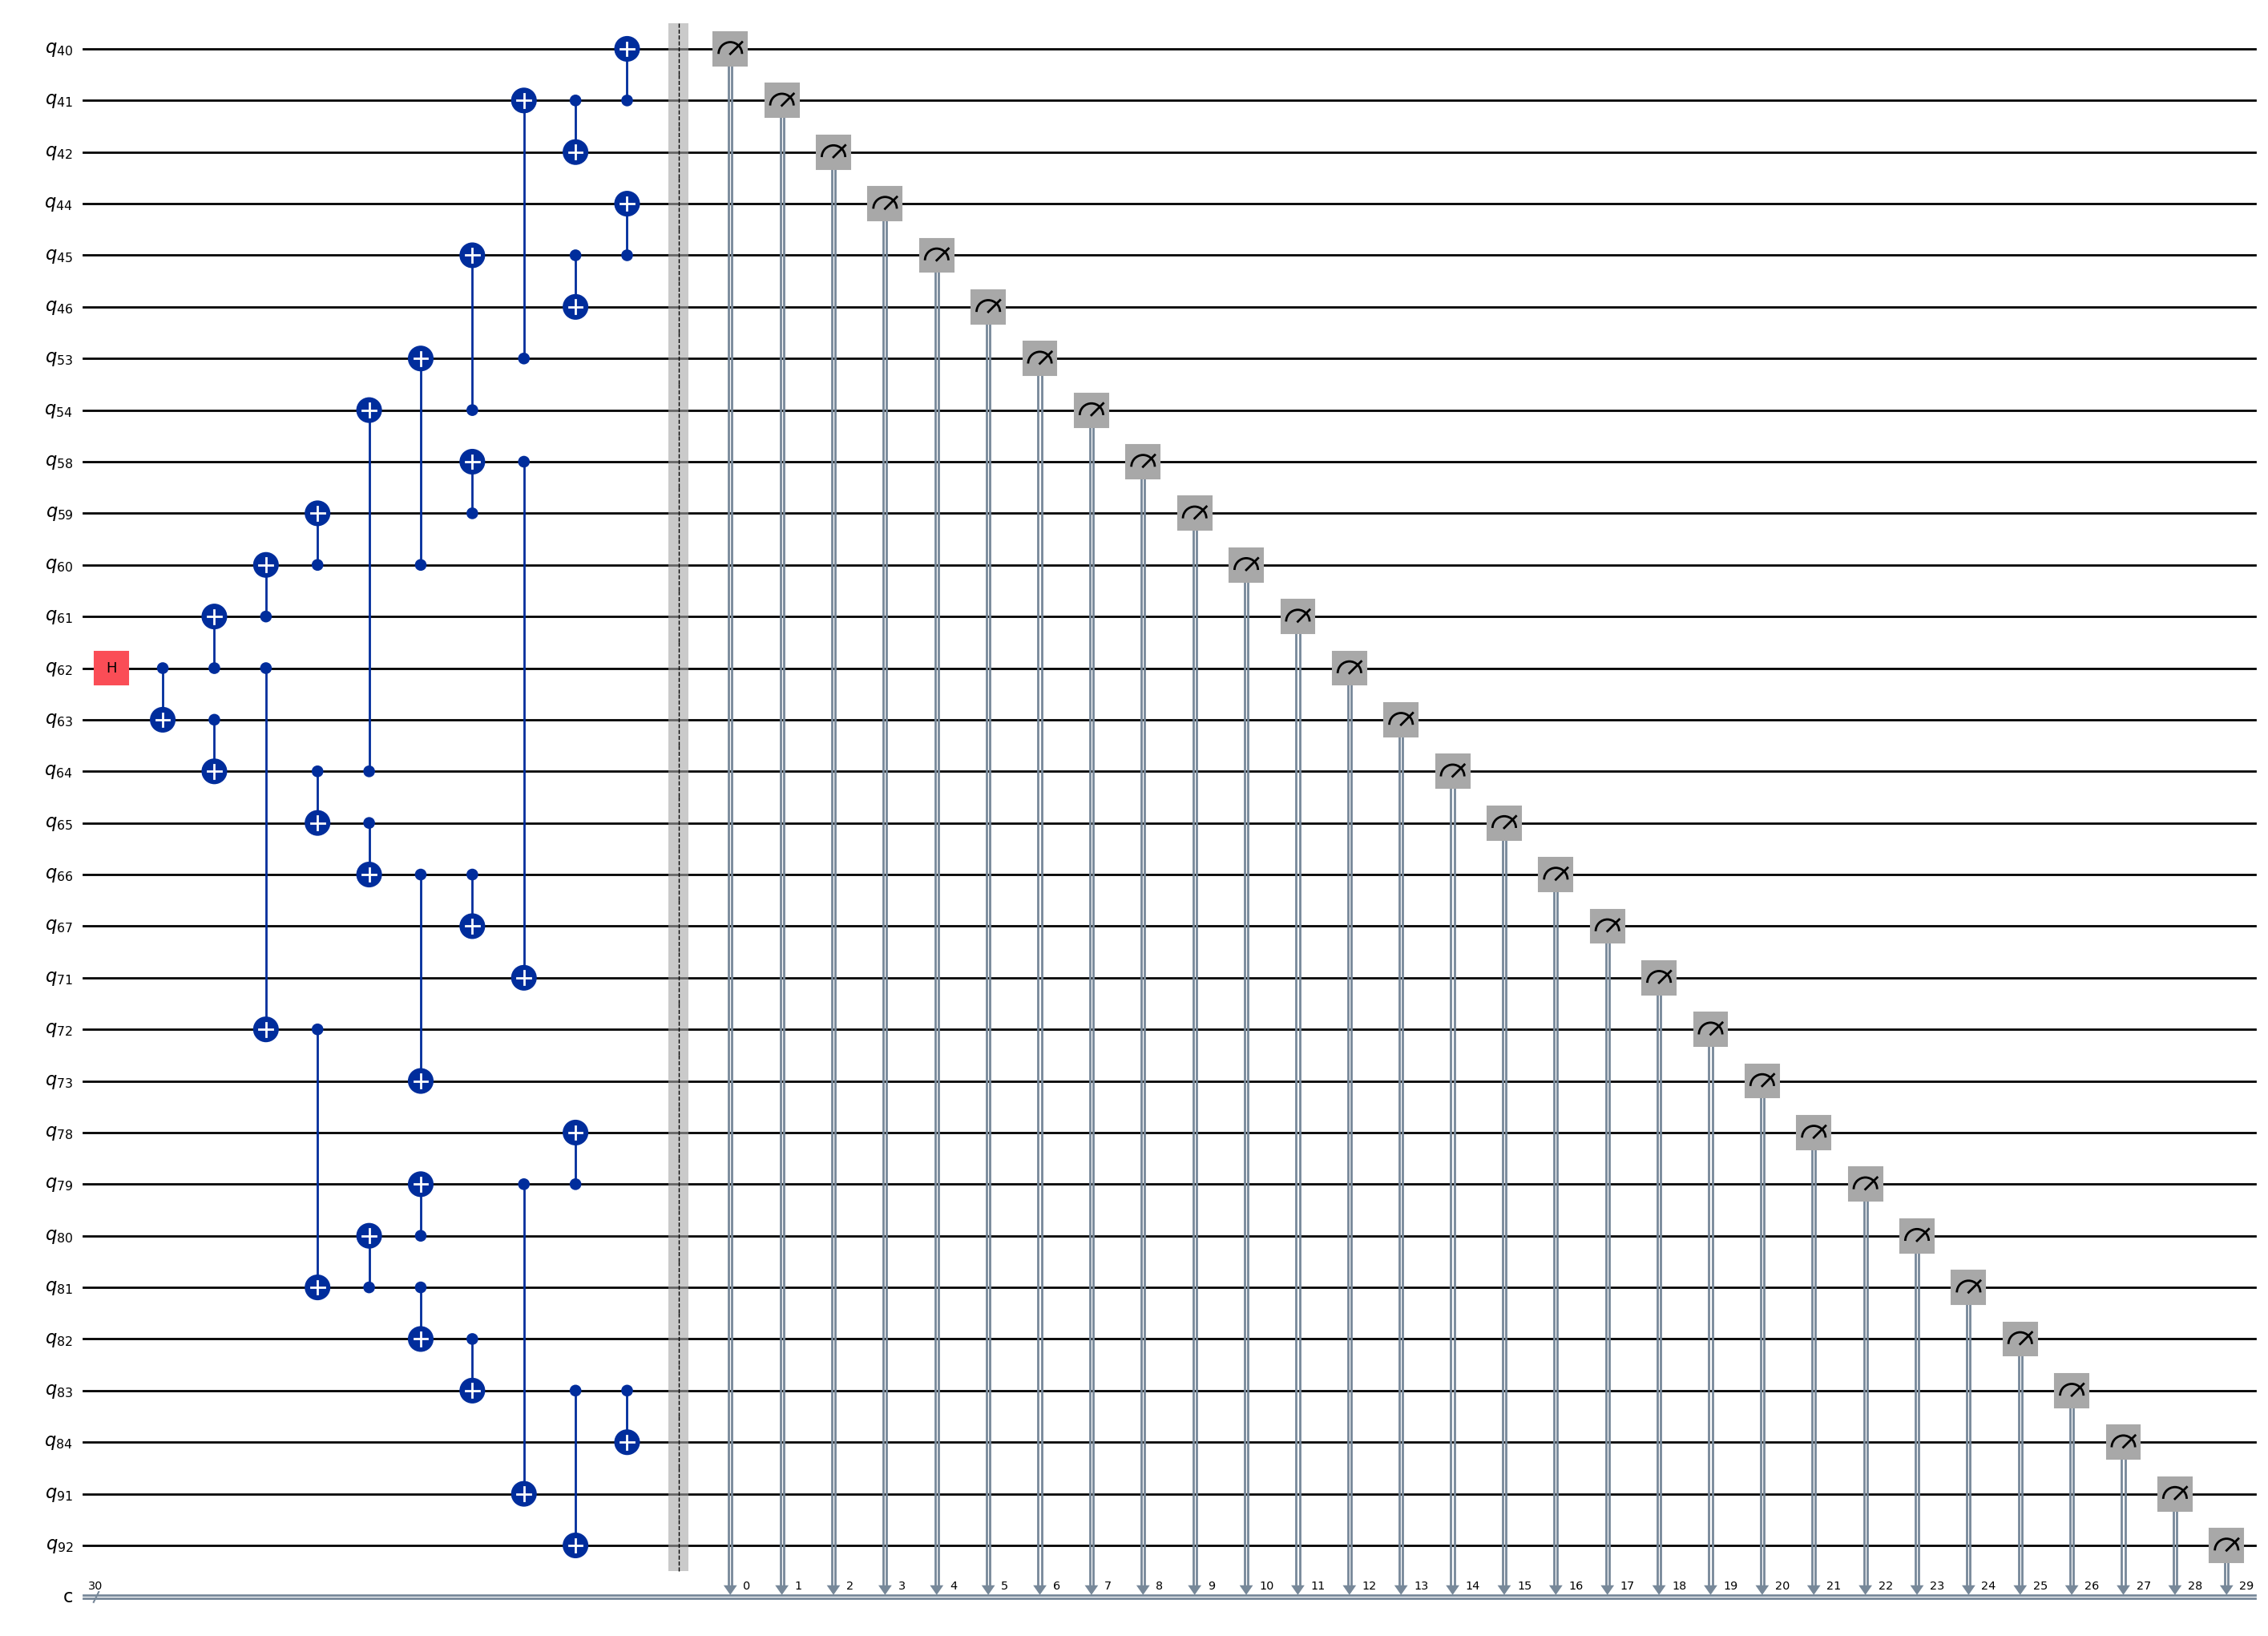

In [26]:
ghz3 = QuantumCircuit(max(best_qubits)+1, N)

ghz3.h(tree.edge_list()[0][0]) # apply H-gate to the root node
# Apply CNOT from the root node to the each edge.
for u, v in tree.edge_list():
    ghz3.cx(u, v)
ghz3.barrier()  # for visualization
ghz3.measure(best_qubits, list(range(N)))
ghz3.draw(output="mpl", idle_wires=False, fold=-1)

In [27]:
ghz3.depth()

11

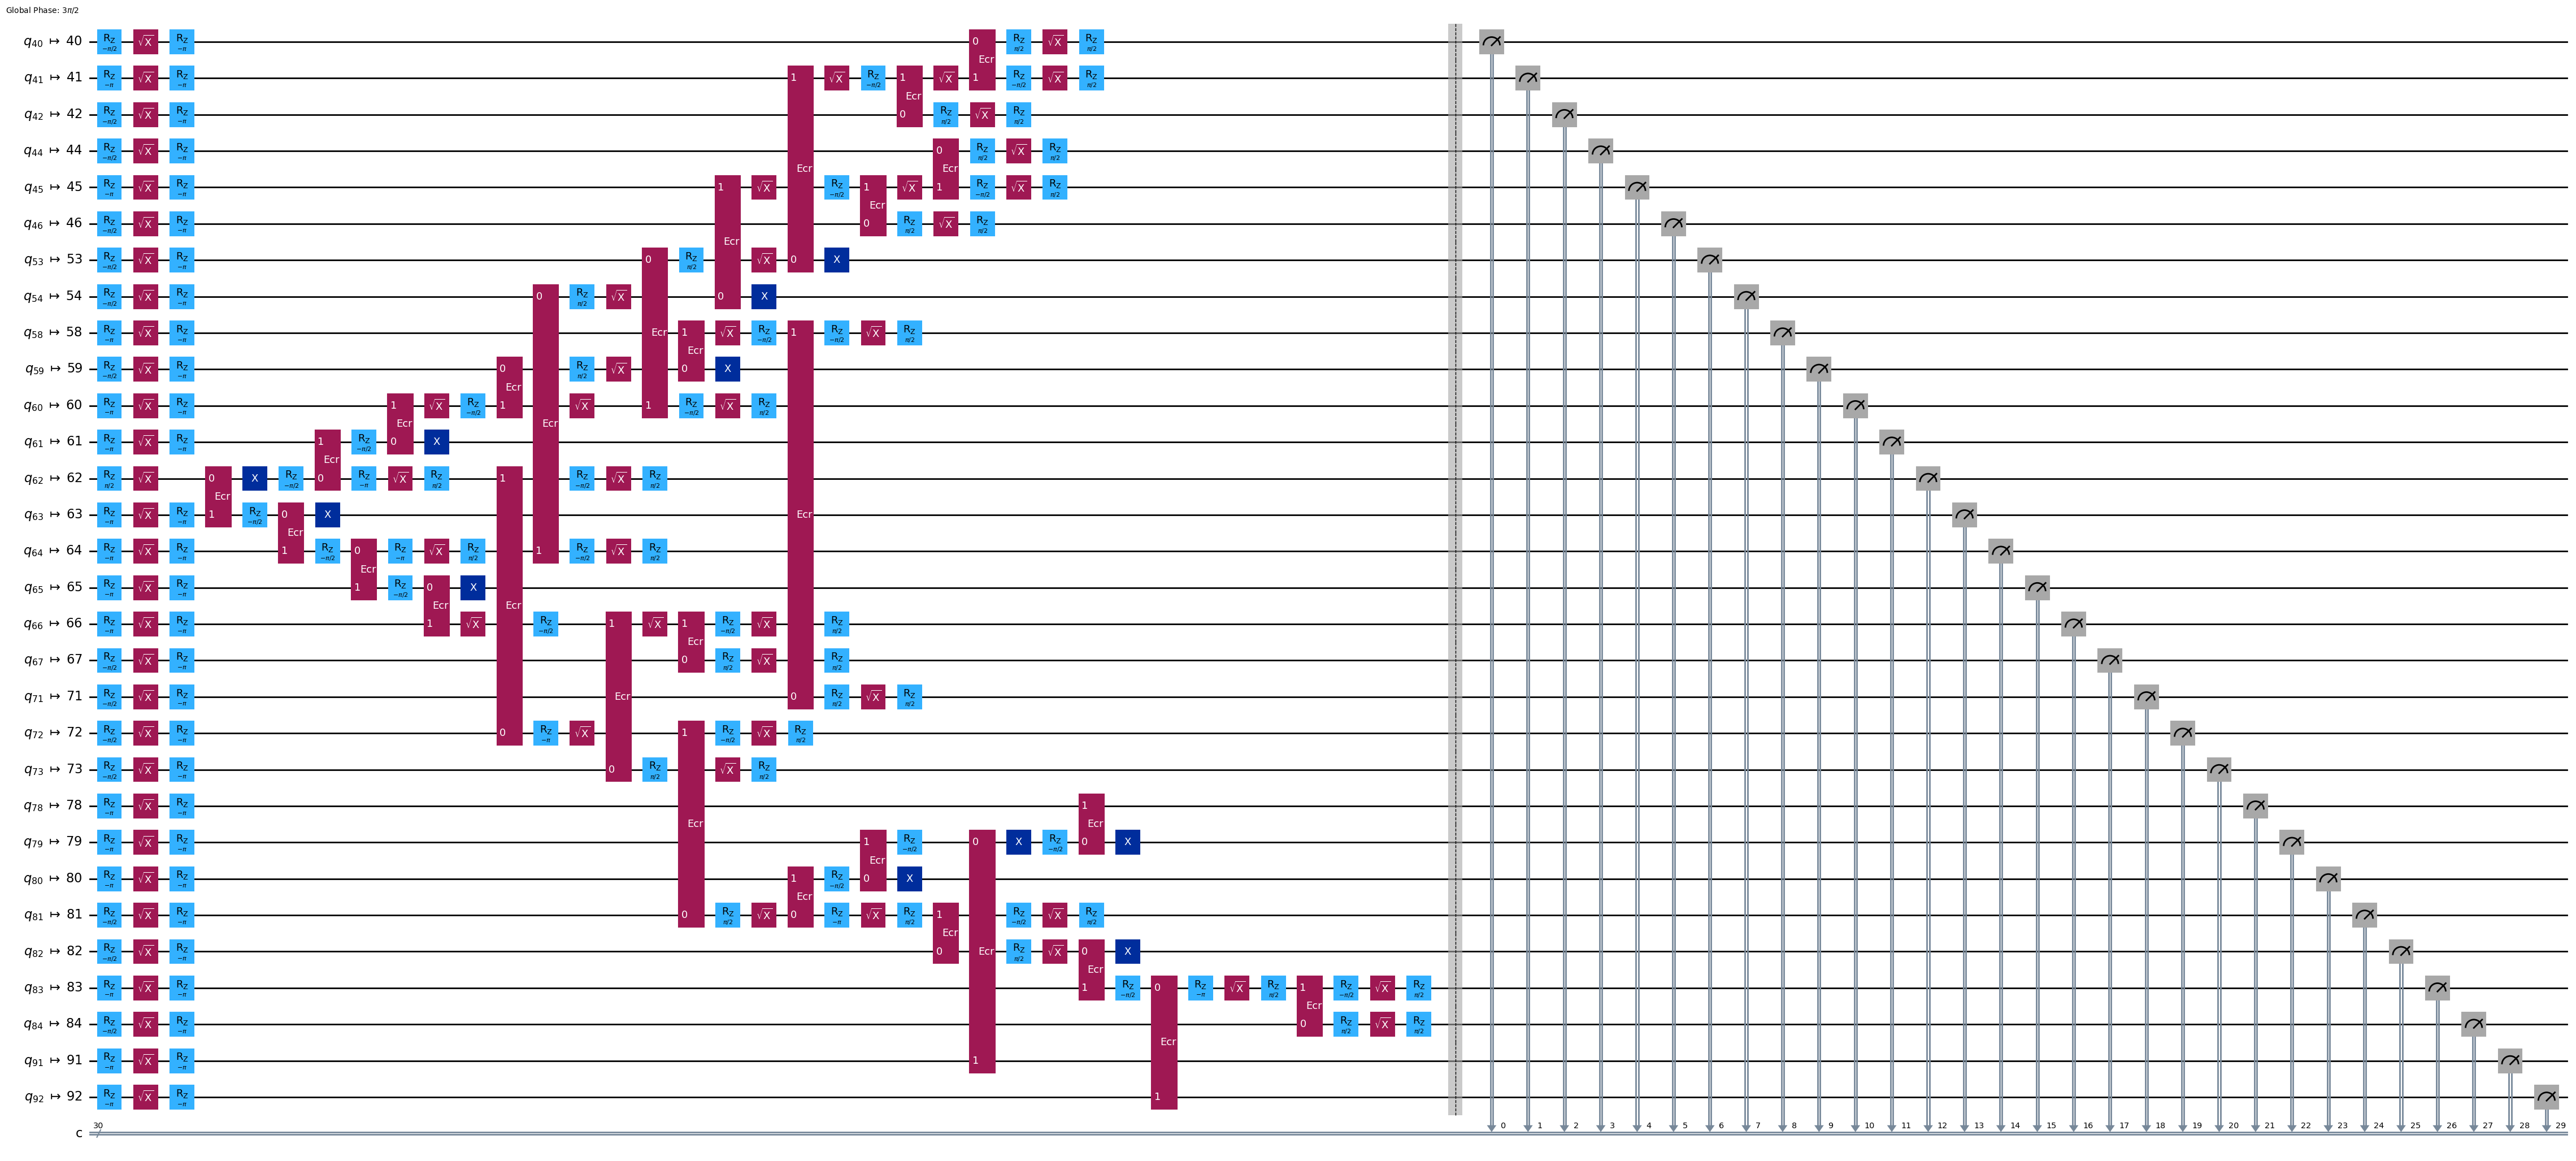

In [28]:
pm = generate_preset_pass_manager(1, backend=backend)
ghz3_transpiled = pm.run(ghz3)
ghz3_transpiled.draw(output="mpl", idle_wires=False, fold=-1)

In [29]:
print('Depth:', ghz3_transpiled.depth())
print('Two-qubit Depth:', ghz3_transpiled.depth(filter_function=lambda x: x.operation.num_qubits==2))

Depth: 34
Two-qubit Depth: 9


### Select a different root node manually

In [30]:
central = 54

vis = TreeEdgesRecorder(N)
rx.bfs_search(g, [central], vis)
best_qubits = sorted(list(set(q for e in vis.edges for q in (e[0], e[1]))))
print('Qubits selected:', best_qubits)

Qubits selected: [24, 34, 35, 41, 42, 43, 44, 45, 46, 47, 48, 49, 54, 55, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 72, 73, 81, 84, 85, 86]


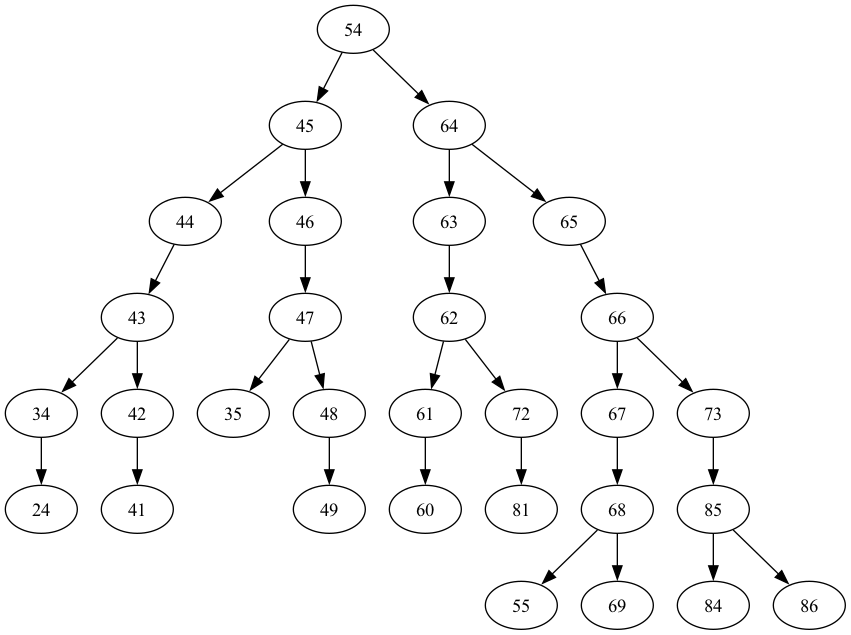

In [31]:
from rustworkx.visualization import graphviz_draw
tree = rx.PyDiGraph()
tree.extend_from_weighted_edge_list(vis.edges)
tree.remove_nodes_from([n for n in range(max(best_qubits)+1) if n not in best_qubits])

graphviz_draw(tree, method='dot')

The depth of this tree is 6.

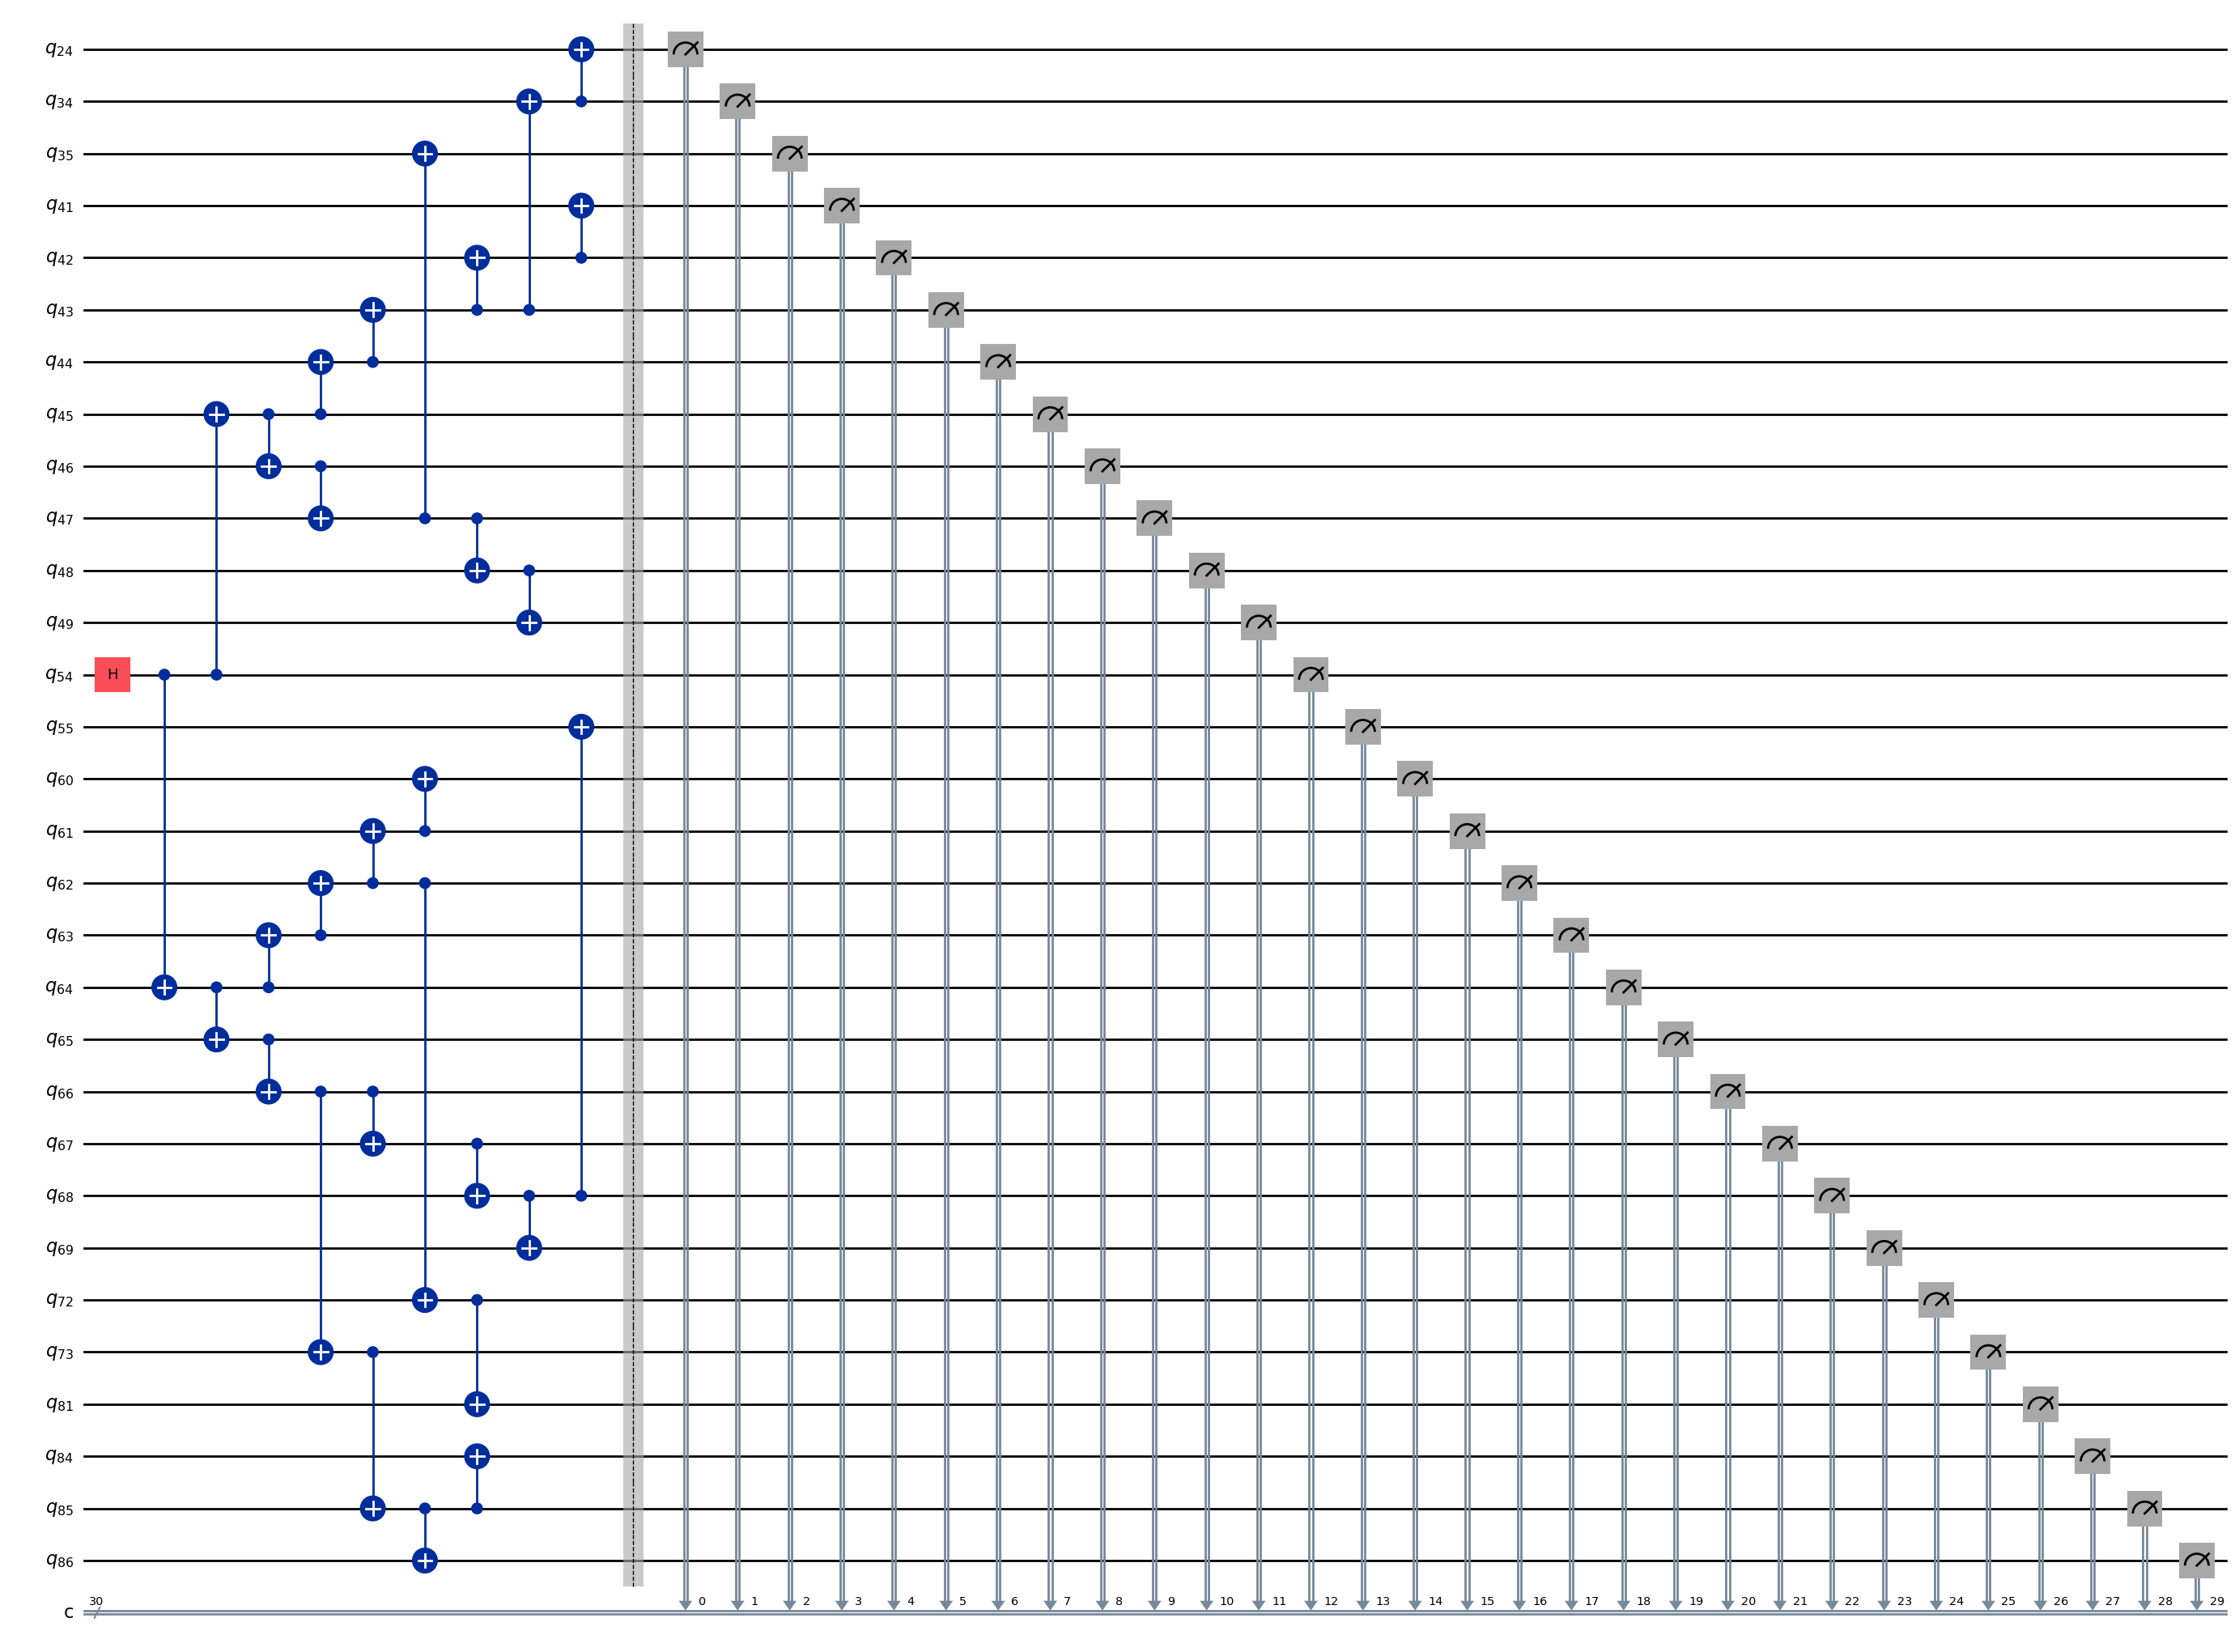

In [32]:
ghz3 = QuantumCircuit(max(best_qubits)+1, N)

ghz3.h(tree.edge_list()[0][0]) # apply H-gate to the root node
# Apply CNOT from the root node to the each edge.
for u, v in tree.edge_list():
    ghz3.cx(u, v)
ghz3.barrier()  # for visualization
ghz3.measure(best_qubits, list(range(N)))
ghz3.draw(output="mpl", idle_wires=False, fold=-1)

In [33]:
ghz3.depth()

10

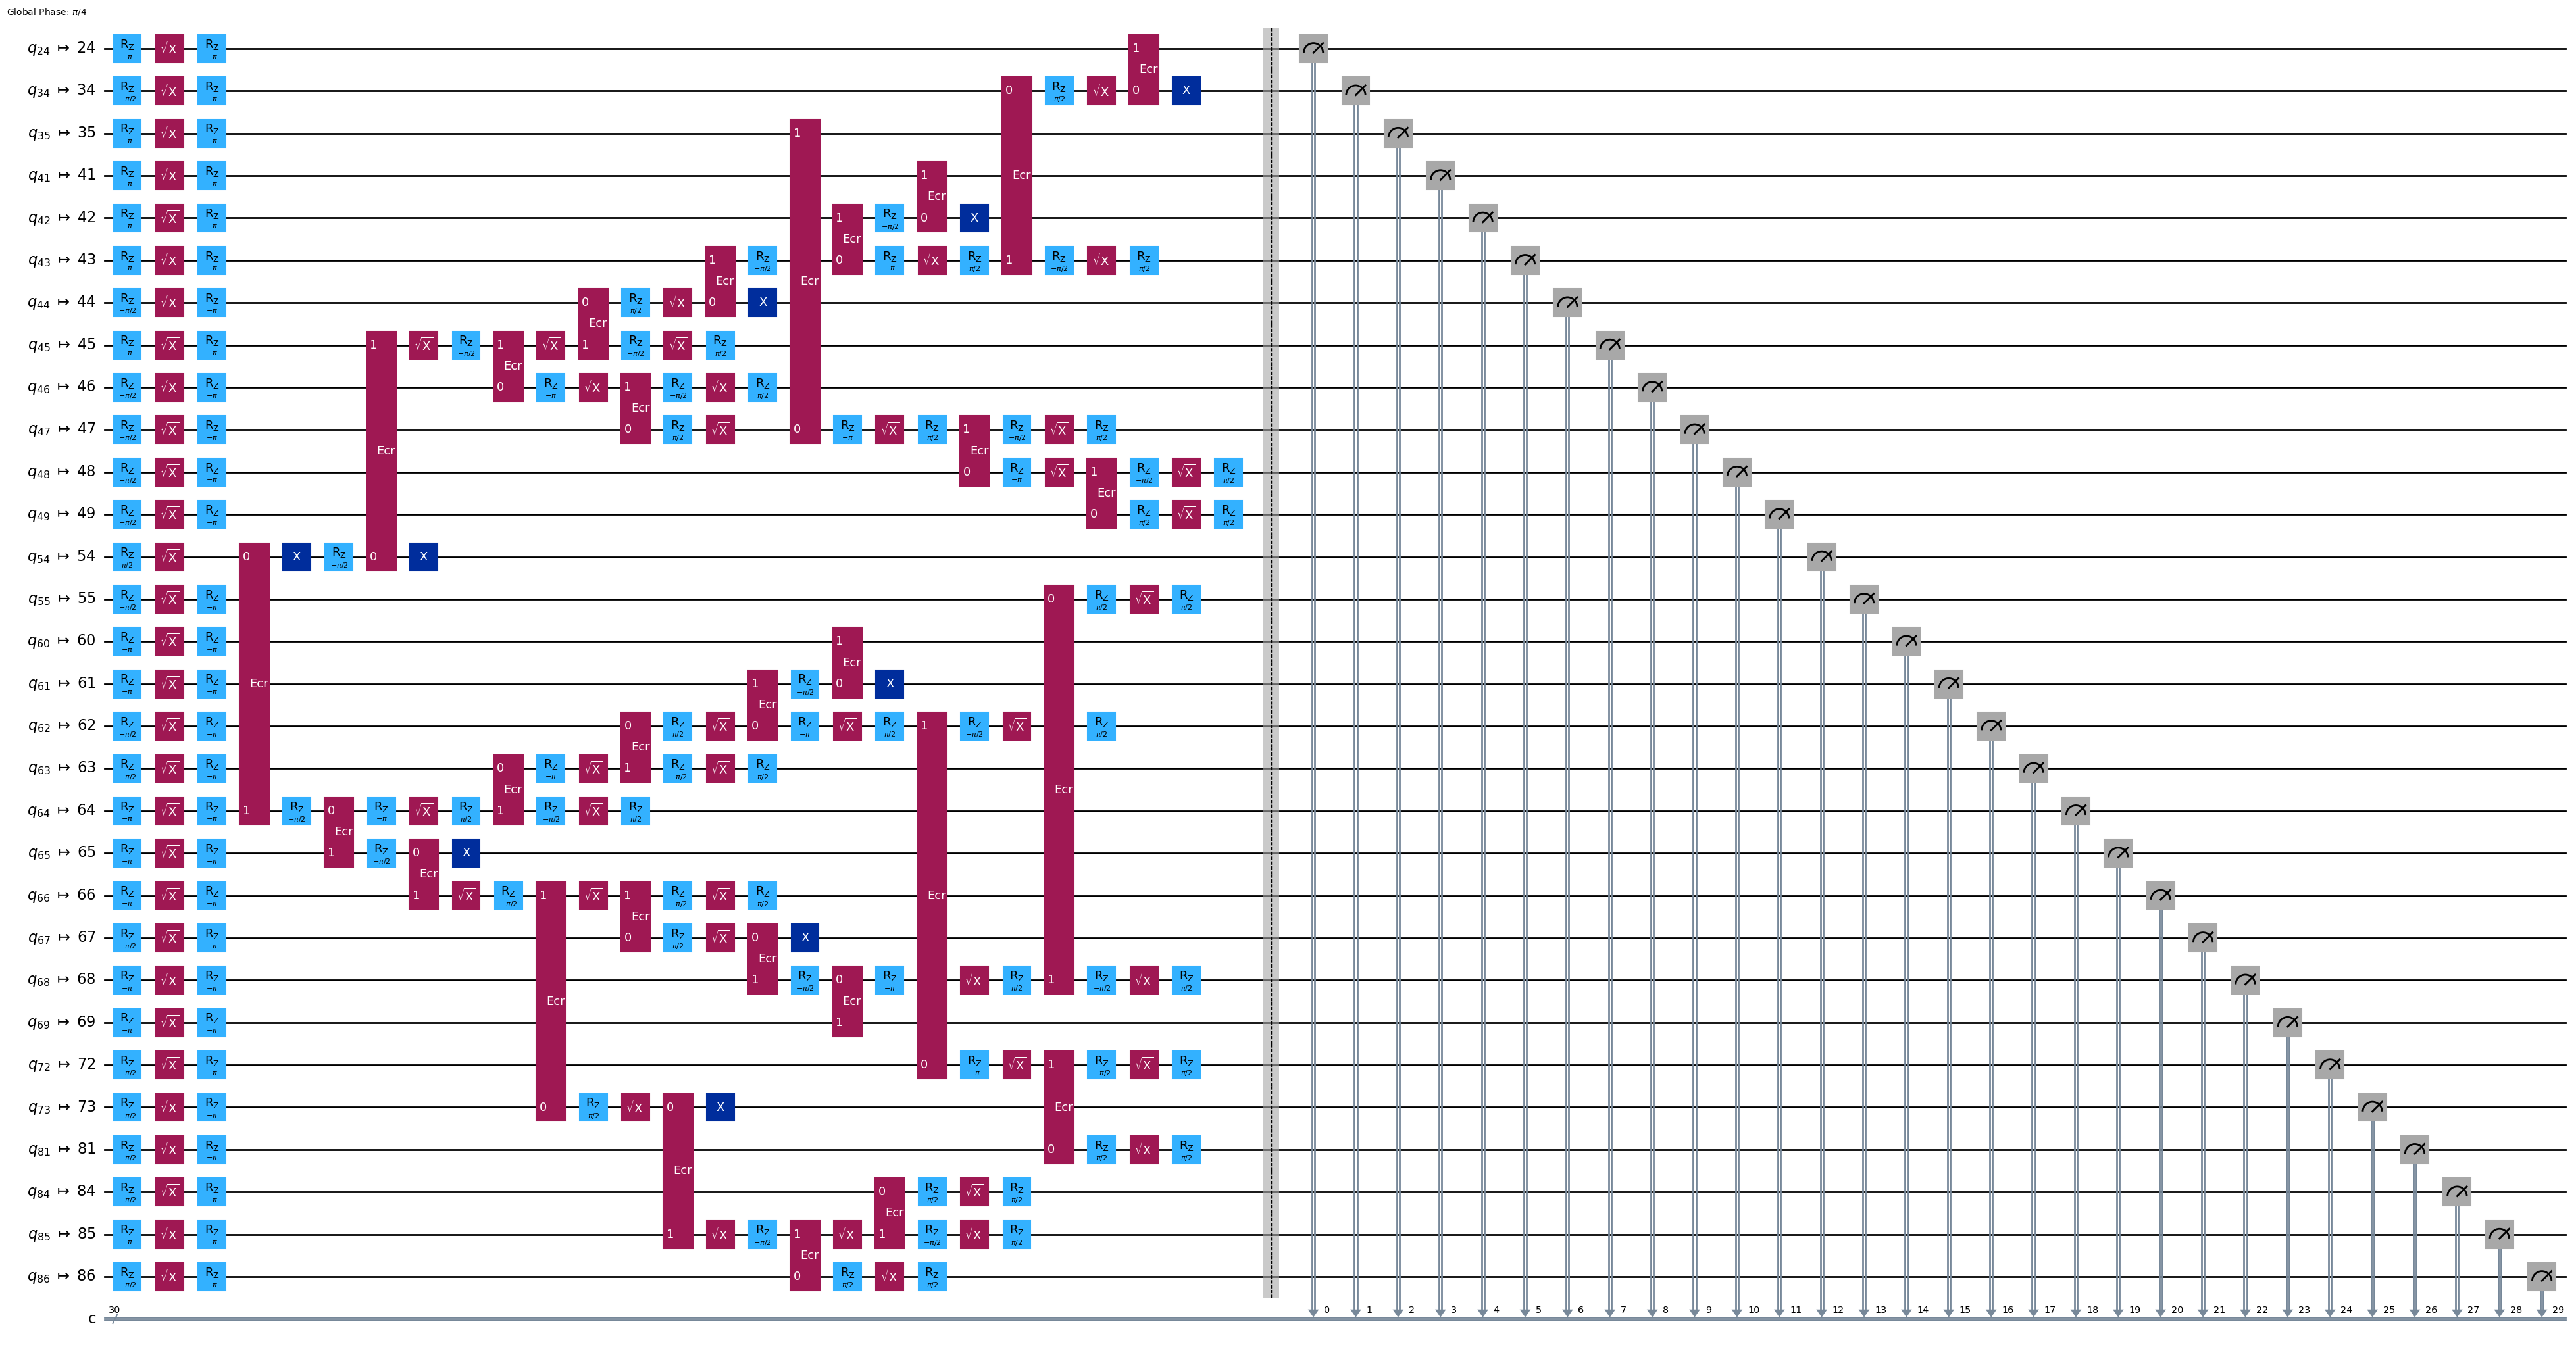

In [34]:
pm = generate_preset_pass_manager(1, backend=backend)
ghz3_transpiled = pm.run(ghz3)
ghz3_transpiled.draw(output="mpl", idle_wires=False, fold=-1)

In [35]:
print('Depth:', ghz3_transpiled.depth())
print('Two-qubit Depth:', ghz3_transpiled.depth(filter_function=lambda x: x.operation.num_qubits==2))

Depth: 27
Two-qubit Depth: 8


Surprisingly, while the tree depth increased from 5 to 6, the two-qubit depth decreased from 9 to 8! So let us use the latter circuit.

**Step 3: Execute on target hardware**

In [38]:
res = execute_ghz_fidelity(
    ghz_circuit=ghz3,
    physical_qubits=best_qubits,
    backend=backend,
    sampler_options=opts,
)

Sampler job id: cv3ywhjx55b0008d33wg, shots=40000
Estimator job id: cv3ywjtx55b0008d33xg


In [41]:
job_s = service.job('cv3ywhjx55b0008d33wg') # Use your job id showed above. 
job_e = service.job('cv3ywjtx55b0008d33xg')
print(job_s.status(), job_e.status())

DONE DONE


**Step 4: Post-process results**

In [42]:
N=30
# Check fidelity from job IDs
res = check_ghz_fidelity_from_jobs(
    sampler_job=job_s,
    estimator_job=job_e,
    num_qubits=N,
)

N=30: |00..0>: 0, |11..1>: 1821, |3rd>: 676 (000000000101100000000010000000)
P(|00..0>)=0.0, P(|11..1>)=0.045525
REM: Coherence (non-diagonal): 0.478084
GHZ fidelity = 0.261805 ± 0.011188
GME (genuinely multipartite entangled) test: Failed


As you can see, this result has not met the criteria.

In [ ]:
# It will take some time
result = job_s.result()
plot_histogram(result[0].data.c.get_counts(), figsize=(30, 5))

## Strategy 3. Run with the error suppression options

You can set the error suppression options in Sampler V2. Please refer https://docs.quantum.ibm.com/guides/configure-error-mitigation#advanced-error, and https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/dev/qiskit_ibm_runtime.options.ExecutionOptionsV2

In [39]:
opts = SamplerOptions()
opts.dynamical_decoupling.enable = True
opts.execution.rep_delay = 0.0005
opts.twirling.enable_gates = True

In [40]:
res = execute_ghz_fidelity(
    ghz_circuit=ghz3,
    physical_qubits=best_qubits,
    backend=backend,
    sampler_options=opts,
)

Sampler job id: cv3ywvkfkm5g008xxe2g, shots=40000
Estimator job id: cv3ywzbqxmm0008vrzt0


In [44]:
job_s = service.job('cv3ywvkfkm5g008xxe2g') # Use your job id showed above. 
job_e = service.job('cv3ywzbqxmm0008vrzt0')
print(job_s.status(), job_e.status())

DONE DONE


In [45]:
N = 30

In [46]:
# Check fidelity from job IDs
res = check_ghz_fidelity_from_jobs(
    sampler_job=job_s,
    estimator_job=job_e,
    num_qubits=N,
)

N=30: |00..0>: 2314, |11..1>: 2212, |3rd>: 330 (111011111111111111111111111111)
P(|00..0>)=0.05785, P(|11..1>)=0.0553
REM: Coherence (non-diagonal): 0.492400
GHZ fidelity = 0.302775 ± 0.011243
GME (genuinely multipartite entangled) test: Failed


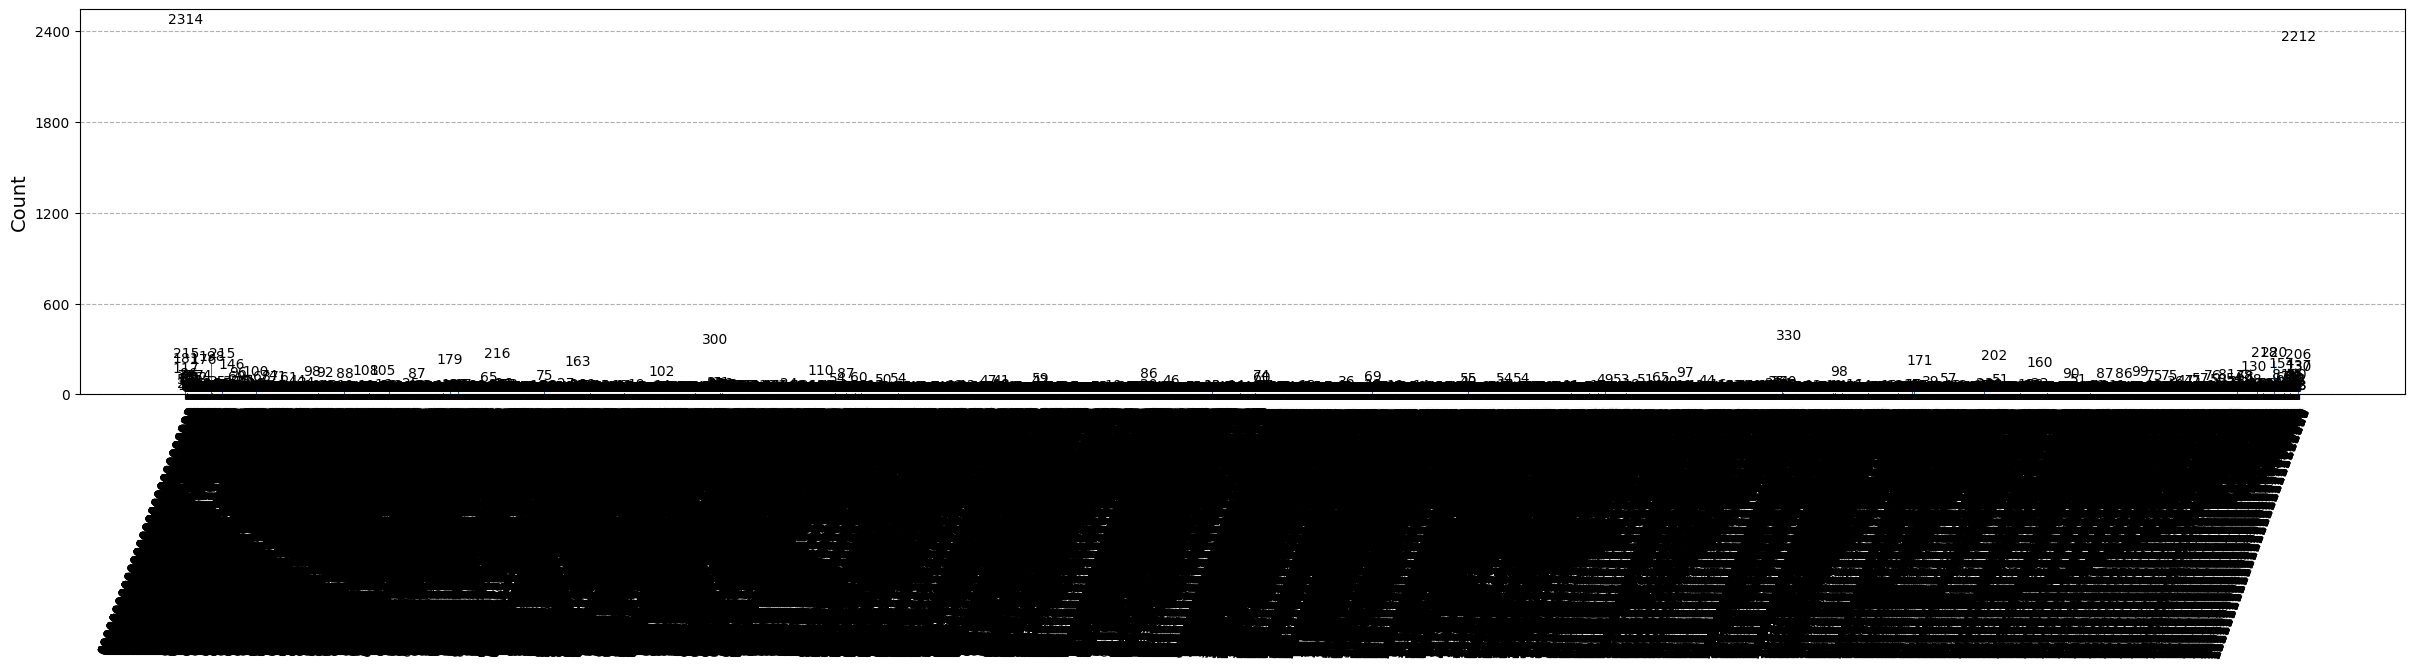

In [47]:
# It will take some time
result = job_s.result()
plot_histogram(result[0].data.c.get_counts(), figsize=(30, 5))

The result has improved but still has not met the criteria.

We have seen three ideas so far. You can combine and expand these ideas or you come up with your own ideas to create a better GHZ circuit. Now let's review the goal again.

# 4. Strategy 3. Run with the error suppression options
You can set the error suppression options in Sampler V2. Please this [guide](https://docs.quantum.ibm.com/guides/configure-error-mitigation#advanced-error), and this [documentation](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/dev/options-execution-options-v2).

In [2]:
opts = SamplerOptions()
opts.dynamical_decoupling.enable = True
opts.execution.rep_delay = 0.0005
opts.twirling.enable_gates = True

In [3]:
res = execute_ghz_fidelity(
    ghz_circuit=ghz3,
    physical_qubits=best_qubits,
    backend=backend,
    sampler_options=opts,
)

NameError: name 'execute_ghz_fidelity' is not defined

In [4]:
job_s = service.job('cv3ywvkfkm5g008xxe2g') # Use your job id showed above. 
job_e = service.job('cv3ywzbqxmm0008vrzt0')
print(job_s.status(), job_e.status())

NameError: name 'service' is not defined

In [ ]:
N = 30

In [ ]:
# Check fidelity from job IDs
res = check_ghz_fidelity_from_jobs(
    sampler_job=job_s,
    estimator_job=job_e,
    num_qubits=N,
)

In [ ]:
# It will take some time
result = job_s.result()
plot_histogram(result[0].data.c.get_counts(), figsize=(30, 5))

The result has improved but still has not met the criteria.

We have seen three ideas so far. You can combine and expand these ideas or you come up with your own ideas to create a better GHZ circuit. Now let's review the goal again.

## 5. Your goal (Recap)
    
Build a GHZ circuit for 20 qubits or more so that the measurement result meets the criteria: **The fidelity of your GHZ state > 0.5.**

- You need to use an Eagle device (`ibm_kyiv`, etc.) and set the shots number as 40,000.
- You should execute the GHZ circuit using the `execute_ghz_fidelity` function, and calculate the fidelity using the `check_ghz_fidelity_from_jobs` function.

You need to find the biggest qubits - GHZ circuit which meet the criteria. Write your code below, show the result with the function `check_ghz_fidelity_from_jobs`, and submit this notebook.

In [ ]:
#service = QiskitRuntimeService(instance="ibm-q-utokyo/internal/qc2024s")
service = QiskitRuntimeService()
backend = service.backend("ibm_torino")
#backend = service.backend("ibm_fez")

twoq_gate = "cz"
print(f"Device {backend.name} Loaded with {backend.num_qubits} qubits")
print(f"Two Qubit Gate: {twoq_gate}")

In [ ]:
BAD_READOUT_ERROR_THRESHOLD = 0.1
BAD_CZGATE_ERROR_THRESHOLD = 0.1
bad_readout_qubits = [q for q in range(backend.num_qubits) if backend.target["measure"][(q, )].error > BAD_READOUT_ERROR_THRESHOLD]
bad_czgate_edges = [qpair for qpair in backend.target["cz"] if backend.target["cz"][qpair].error > BAD_CZGATE_ERROR_THRESHOLD]
print("Bad readout qubits:", bad_readout_qubits)
print("Bad CZ gates:", bad_czgate_edges)

In [ ]:
g = backend.coupling_map.graph.copy().to_undirected()
g.remove_edges_from(bad_czgate_edges)  # remove edge first (otherwise may fail with a NoEdgeBetweenNodes error)
g.remove_nodes_from(bad_readout_qubits)

In [ ]:
N = 40
central = 100 #Select the center node manually
#c_degree = dict(rx.betweenness_centrality(g))
#central = max(c_degree, key=c_degree.get)
#central

In [ ]:
class TreeEdgesRecorder(rx.visit.BFSVisitor):
    def __init__(self, N):
        self.edges = []
        self.N = N

    def tree_edge(self, edge):
        self.edges.append(edge)
        if len(self.edges) >= self.N-1:
            raise rx.visit.StopSearch()

vis = TreeEdgesRecorder(N)
rx.bfs_search(g, [central], vis)
best_qubits = sorted(list(set(q for e in vis.edges for q in (e[0], e[1]))))
print('Qubits selected:', best_qubits)

In [ ]:
qubit_color = []
for i in range(133):
    if i in bad_readout_qubits:
        qubit_color.append("#000000")
    elif i in best_qubits:
        qubit_color.append("#ff00dd")
    else:
        qubit_color.append("#8c00ff")
line_color = []
for e in backend.target.build_coupling_map().get_edges():
    if e in bad_czgate_edges:
        line_color.append("#ffffff")
    else:
        line_color.append("#888888")
plot_gate_map(backend, qubit_color=qubit_color, line_color=line_color, qubit_size=60, font_size=30, figsize=(10, 10))

In [ ]:
from rustworkx.visualization import graphviz_draw
tree = rx.PyDiGraph()
tree.extend_from_weighted_edge_list(vis.edges)
tree.remove_nodes_from([n for n in range(max(best_qubits)+1) if n not in best_qubits])

graphviz_draw(tree, method='dot')

In [ ]:
ghz_h = QuantumCircuit(max(best_qubits)+1, N)

ghz_h.h(tree.edge_list()[0][0]) # apply H-gate to the root node
# Apply CNOT from the root node to the each edge.
for u, v in tree.edge_list():
    ghz_h.cx(u, v)
ghz_h.barrier()  # for visualization
ghz_h.measure(best_qubits, list(range(N)))
ghz_h.draw(output="mpl", idle_wires=False, fold=-1)

In [ ]:
ghz_h.depth()

In [ ]:
pm = generate_preset_pass_manager(1, backend=backend)
ghz_h_transpiled = pm.run(ghz_h)
ghz_h_transpiled.draw(output="mpl", idle_wires=False, fold=-1)

In [ ]:
print('Depth:', ghz_h_transpiled.depth())
print('Two-qubit Depth:', ghz_h_transpiled.depth(filter_function=lambda x: x.operation.num_qubits==2))

In [ ]:
opts = SamplerOptions()
opts.dynamical_decoupling.enable = True
opts.execution.rep_delay = 0.0005
opts.twirling.enable_gates = True

In [ ]:
res = execute_ghz_fidelity(
    ghz_circuit=ghz_h,
    physical_qubits=best_qubits,
    backend=backend,
    sampler_options=opts,
)

In [ ]:
job_s = service.job('cty6x1mzwsvg008ccedg') # Use your job id showed above. 
job_e = service.job('cty6x3wckyk0008a9pp0')
print(job_s.status(), job_e.status())

In [ ]:
# Check fidelity from job IDs
N=40
res = check_ghz_fidelity_from_jobs(
    sampler_job=job_s,
    estimator_job=job_e,
    num_qubits=N,
)